In [1]:
import os
import time

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

import baskerville
from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna as dna_io

import json

import pybedtools
import pysam

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import csv

from borzoi_helpers import *


2025-05-28 20:05:21.755190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 20:05:22.140183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 20:05:22.140339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 20:05:22.207333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 20:05:22.339631: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
#Model configuration

params_file = 'params.json'
targets_file = 'targets_human.txt'

seq_len = 393216
n_folds = 2
rc = True

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

target_slice = np.array(targets_df.index.values, dtype='int32')

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = np.array(targets_df.strand_pair.values, dtype='int32')
    
    #Create local index of strand_pair (relative to sliced targets)
    target_slice_dict = {ix : i for i, ix in enumerate(target_slice.tolist())}
    slice_pair = np.array([target_slice_dict[ix] for ix in strand_pair.tolist()], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "models/f" + str(fold_ix) + "c0/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


In [3]:
#Load genome fasta and gene annotations

#Initialize fasta sequence extractor
fasta_open = pysam.Fastafile('/home/jlinder/borzoi/examples/hg38/assembly/ucsc/hg38.fa')

#Load gene/exon annotation
gtf_file = '/home/jlinder/borzoi/examples/hg38/genes/gencode41/gencode41_basic_nort_protein.gtf'

transcriptome = bgene.Transcriptome(gtf_file)

#Get gene span bedtool
bedt_span = transcriptome.bedtool_span()

#Load APA atlas
apa_df = pd.read_csv('/home/jlinder/borzoi/examples/hg38/genes/polyadb/polyadb_human_v3.csv.gz', sep='\t', compression='gzip')
apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_type', 'pas_type', 'total_count']]

apa_df.loc[apa_df['pas_type'] == 'NoPAS', 'pas_type'] = 'No_CSE'

#Only consider 3' UTR sites
apa_df_utr = apa_df.query("site_type == '3\\' most exon' and pas_type != 'No_CSE'").copy().reset_index(drop=True)

#Or intronic sites
apa_df_intron = apa_df.query("site_type == 'Intron' and pas_type != 'No_CSE'").copy().reset_index(drop=True)

print("len(apa_df_utr) = " + str(len(apa_df_utr)))
print("len(apa_df_intron) = " + str(len(apa_df_intron)))

#Load TSS atlas
tss_df = pd.read_csv('/home/jlinder/borzoi/examples/hg38/genes/gencode41/gencode41_basic_tss2.bed', sep='\t', names=['chrom', 'position_hg38', 'end', 'tss_id', 'feat1', 'strand'])
tss_df['gene'] = tss_df['tss_id'].apply(lambda x: x.split("/")[1] if "/" in x else x)

print("len(tss_df) = " + str(len(tss_df)))


len(apa_df_utr) = 79129
len(apa_df_intron) = 83473
len(tss_df) = 116649


In [4]:
#Predict for WT sequence (target gene)

search_gene = 'ENSG00000081041'

model_subset = None

load_isoforms = False

chrom = None
start = None
end = None

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]
gene_strand = gene.strand

g_start, g_end = gene.span()
gene_width = (g_end - g_start)

#Calculate optimal plot width
plot_width = 0
if gene_width * 1.25 <= 4096 :
    plot_width = 4096
elif gene_width * 1.25 <= 8192 :
    plot_width = 8192
elif gene_width * 1.25 <= 16384 :
    plot_width = 16384
elif gene_width * 1.25 <= 2*16384 :
    plot_width = 2*16384
elif gene_width * 1.25 <= 4*16384 :
    plot_width = 4*16384
elif gene_width * 1.25 <= 6*16384 :
    plot_width = 6*16384
elif gene_width * 1.25 <= 8*16384 :
    plot_width = 8*16384
elif gene_width * 1.25 <= 12*16384 :
    plot_width = 12*16384
else :
    plot_width = 393216

if chrom is None or start is None or end is None :
    chrom = gene.chrom
    mid = (g_start + g_end) // 2
    start = mid - 393216 // 2
    end = mid + 393216 // 2

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)

#Get sequence bedtool
seq_bedt = pybedtools.BedTool('%s %d %d' % (chrom, start, end), from_string=True)

#Get all genes (exons and strands) overlapping input window
gene_ids = []
gene_slices = []
gene_strands = []

#Get 3' UTR pA sites for gene
apa_df_gene_utr = apa_df_utr.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]
apa_df_gene_intron = apa_df_intron.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

#Get TSS sites for gene
tss_df_gene = tss_df.loc[tss_df['gene'].str.contains(search_gene)].copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

#Get gene isoforms
isoform_slices = []

#Get wt sequence
seq_1hot_wt = process_sequence(fasta_open, chrom, start, end, seq_len=seq_len)

#Make wt prediction
y_wt = predict_tracks(models if model_subset is None or len(model_subset) == 0 else model_subset, seq_1hot_wt)


2025-05-28 20:05:52.003029: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-05-28 20:05:52.208916: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-28 20:05:52.683222: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [5]:
#Get stranded targets

def targets_prep_strand(targets_df) :
    
    # attach strand
    targets_strand = []
    for _, target in targets_df.iterrows() :
      if target.strand_pair == target.name :
        targets_strand.append('.')
      else :
        targets_strand.append(target.identifier[-1])
    targets_df['strand'] = targets_strand

    # collapse stranded
    strand_mask = (targets_df.strand != '-')
    targets_strand_df = targets_df[strand_mask]

    return targets_strand_df

targets_strand_df = targets_prep_strand(targets_df)


In [6]:
#Update file path for CAGE/DNASE/RNA tracks

def _update_file_path(row) :
    if 'CAGE:' in row['description'] or 'DNASE:' in row['description'] :
        return row['file'].replace('scratch4/jlinder', 'scratch3/drk')
    elif 'RNA:' in row['description'] and row['source'] in ['encode', 'recount3'] :
        return row['file'].replace('scratch4/jlinder', 'scratch3/drk')
    else :
        return row['file']

targets_df['file'] = targets_df.apply(_update_file_path, axis=1)


--- Predicted (Borzoi) ---


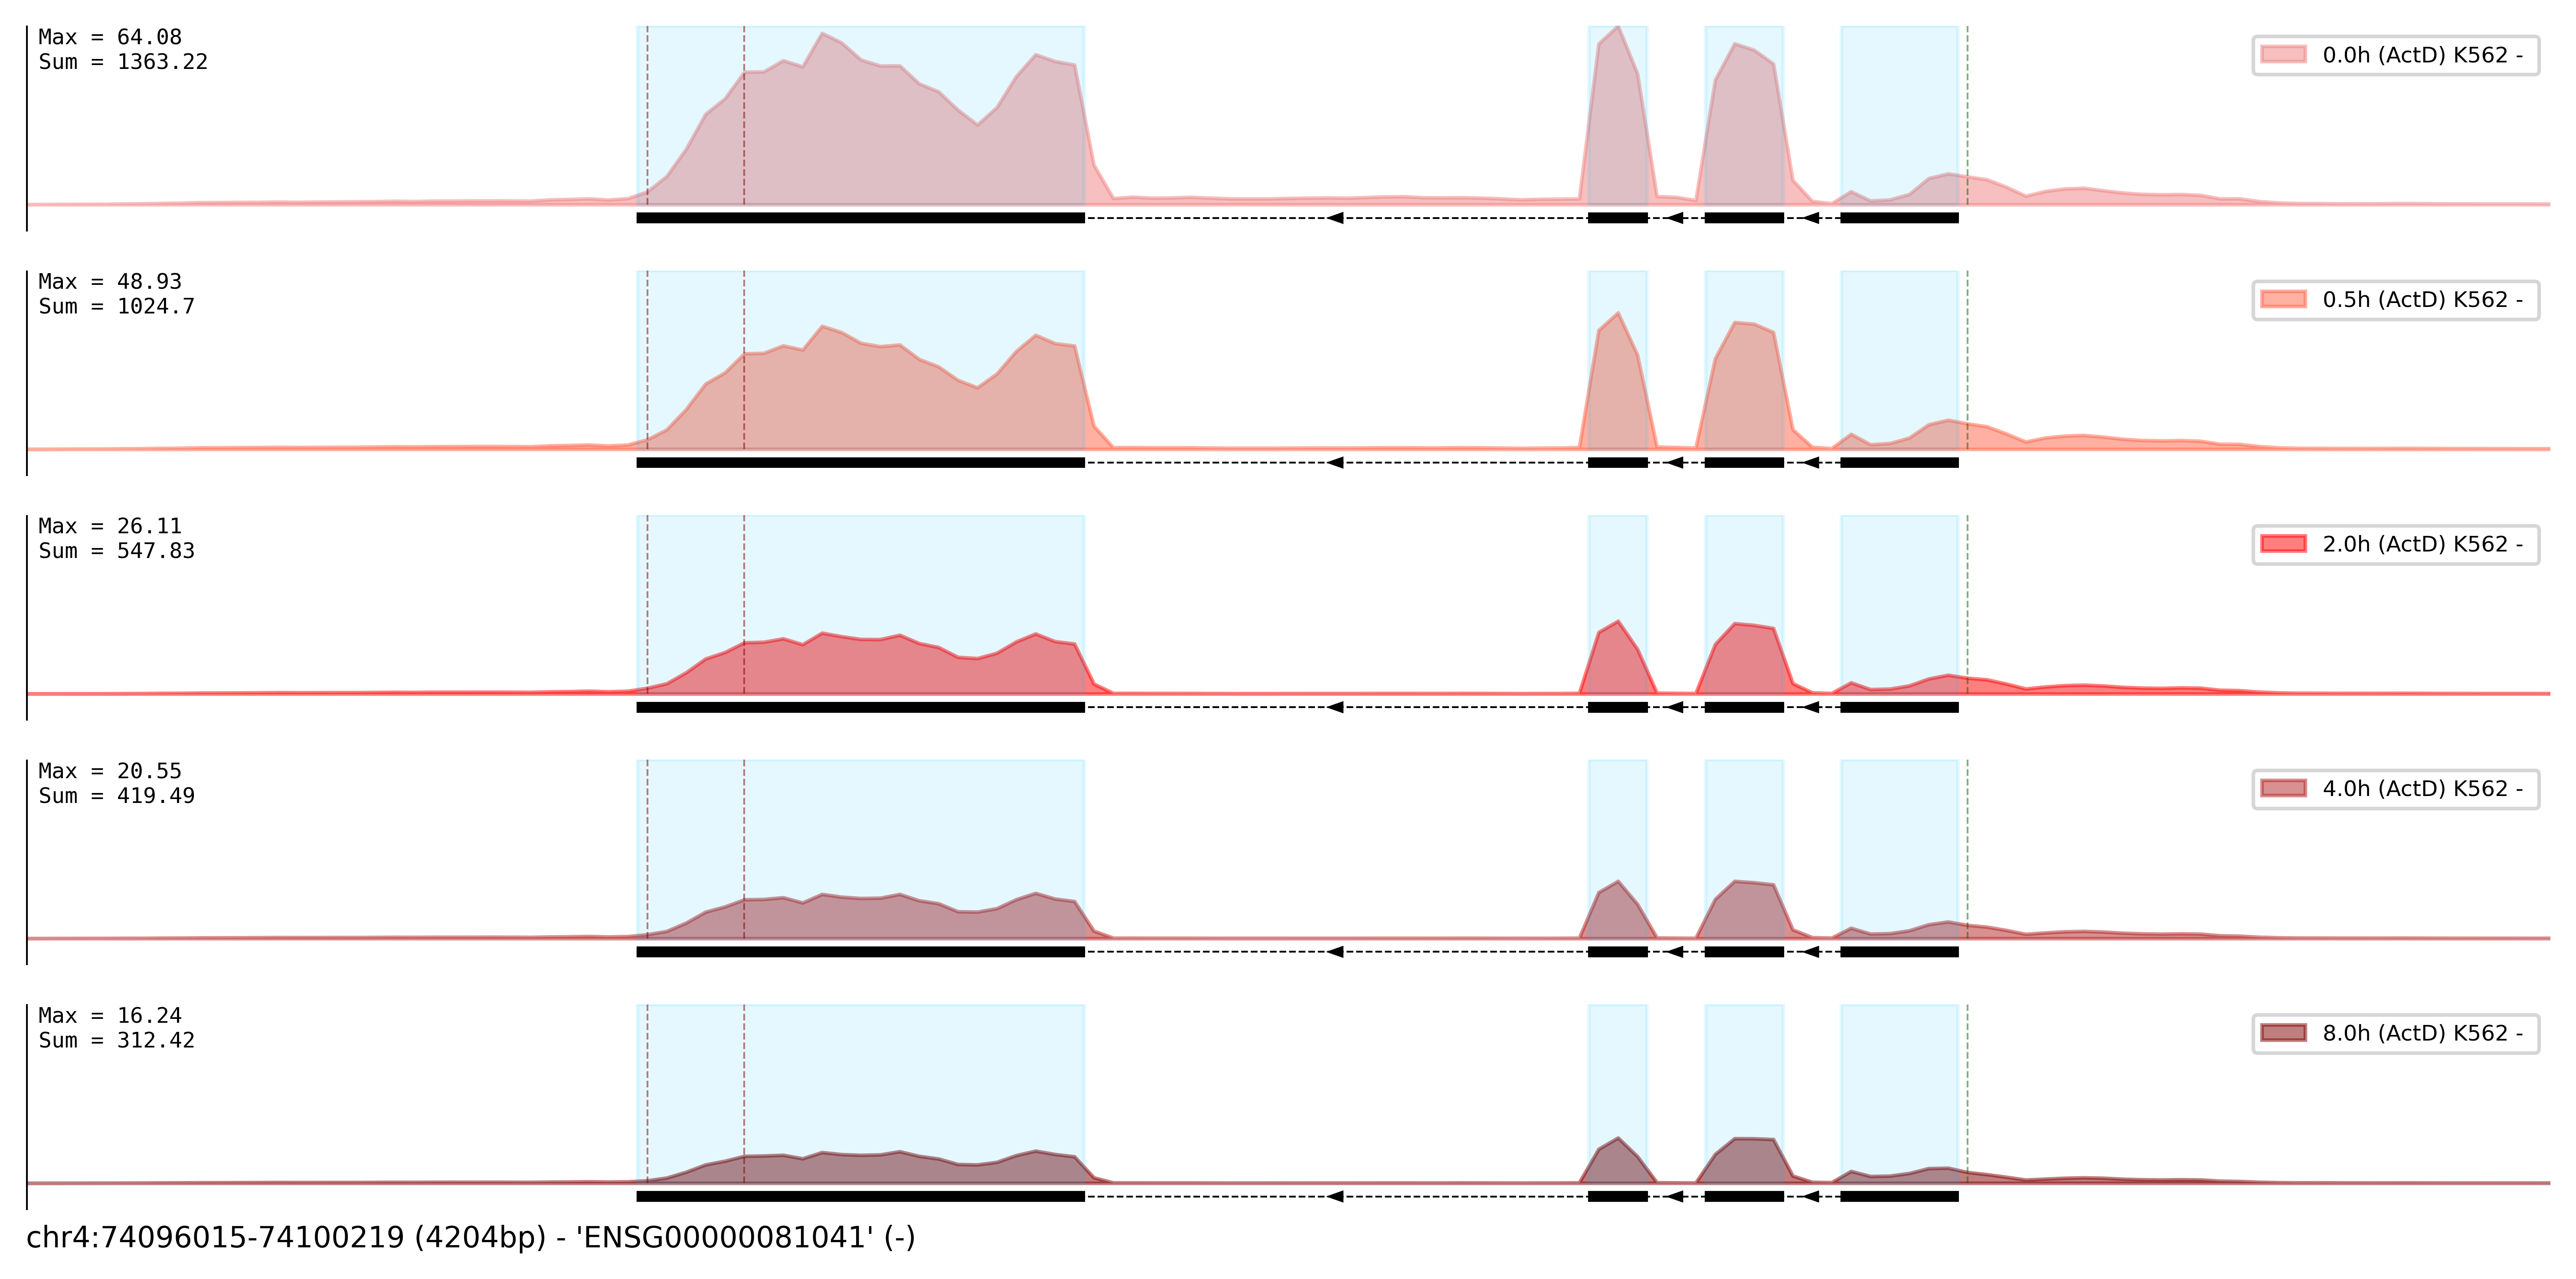

--- Measured ---


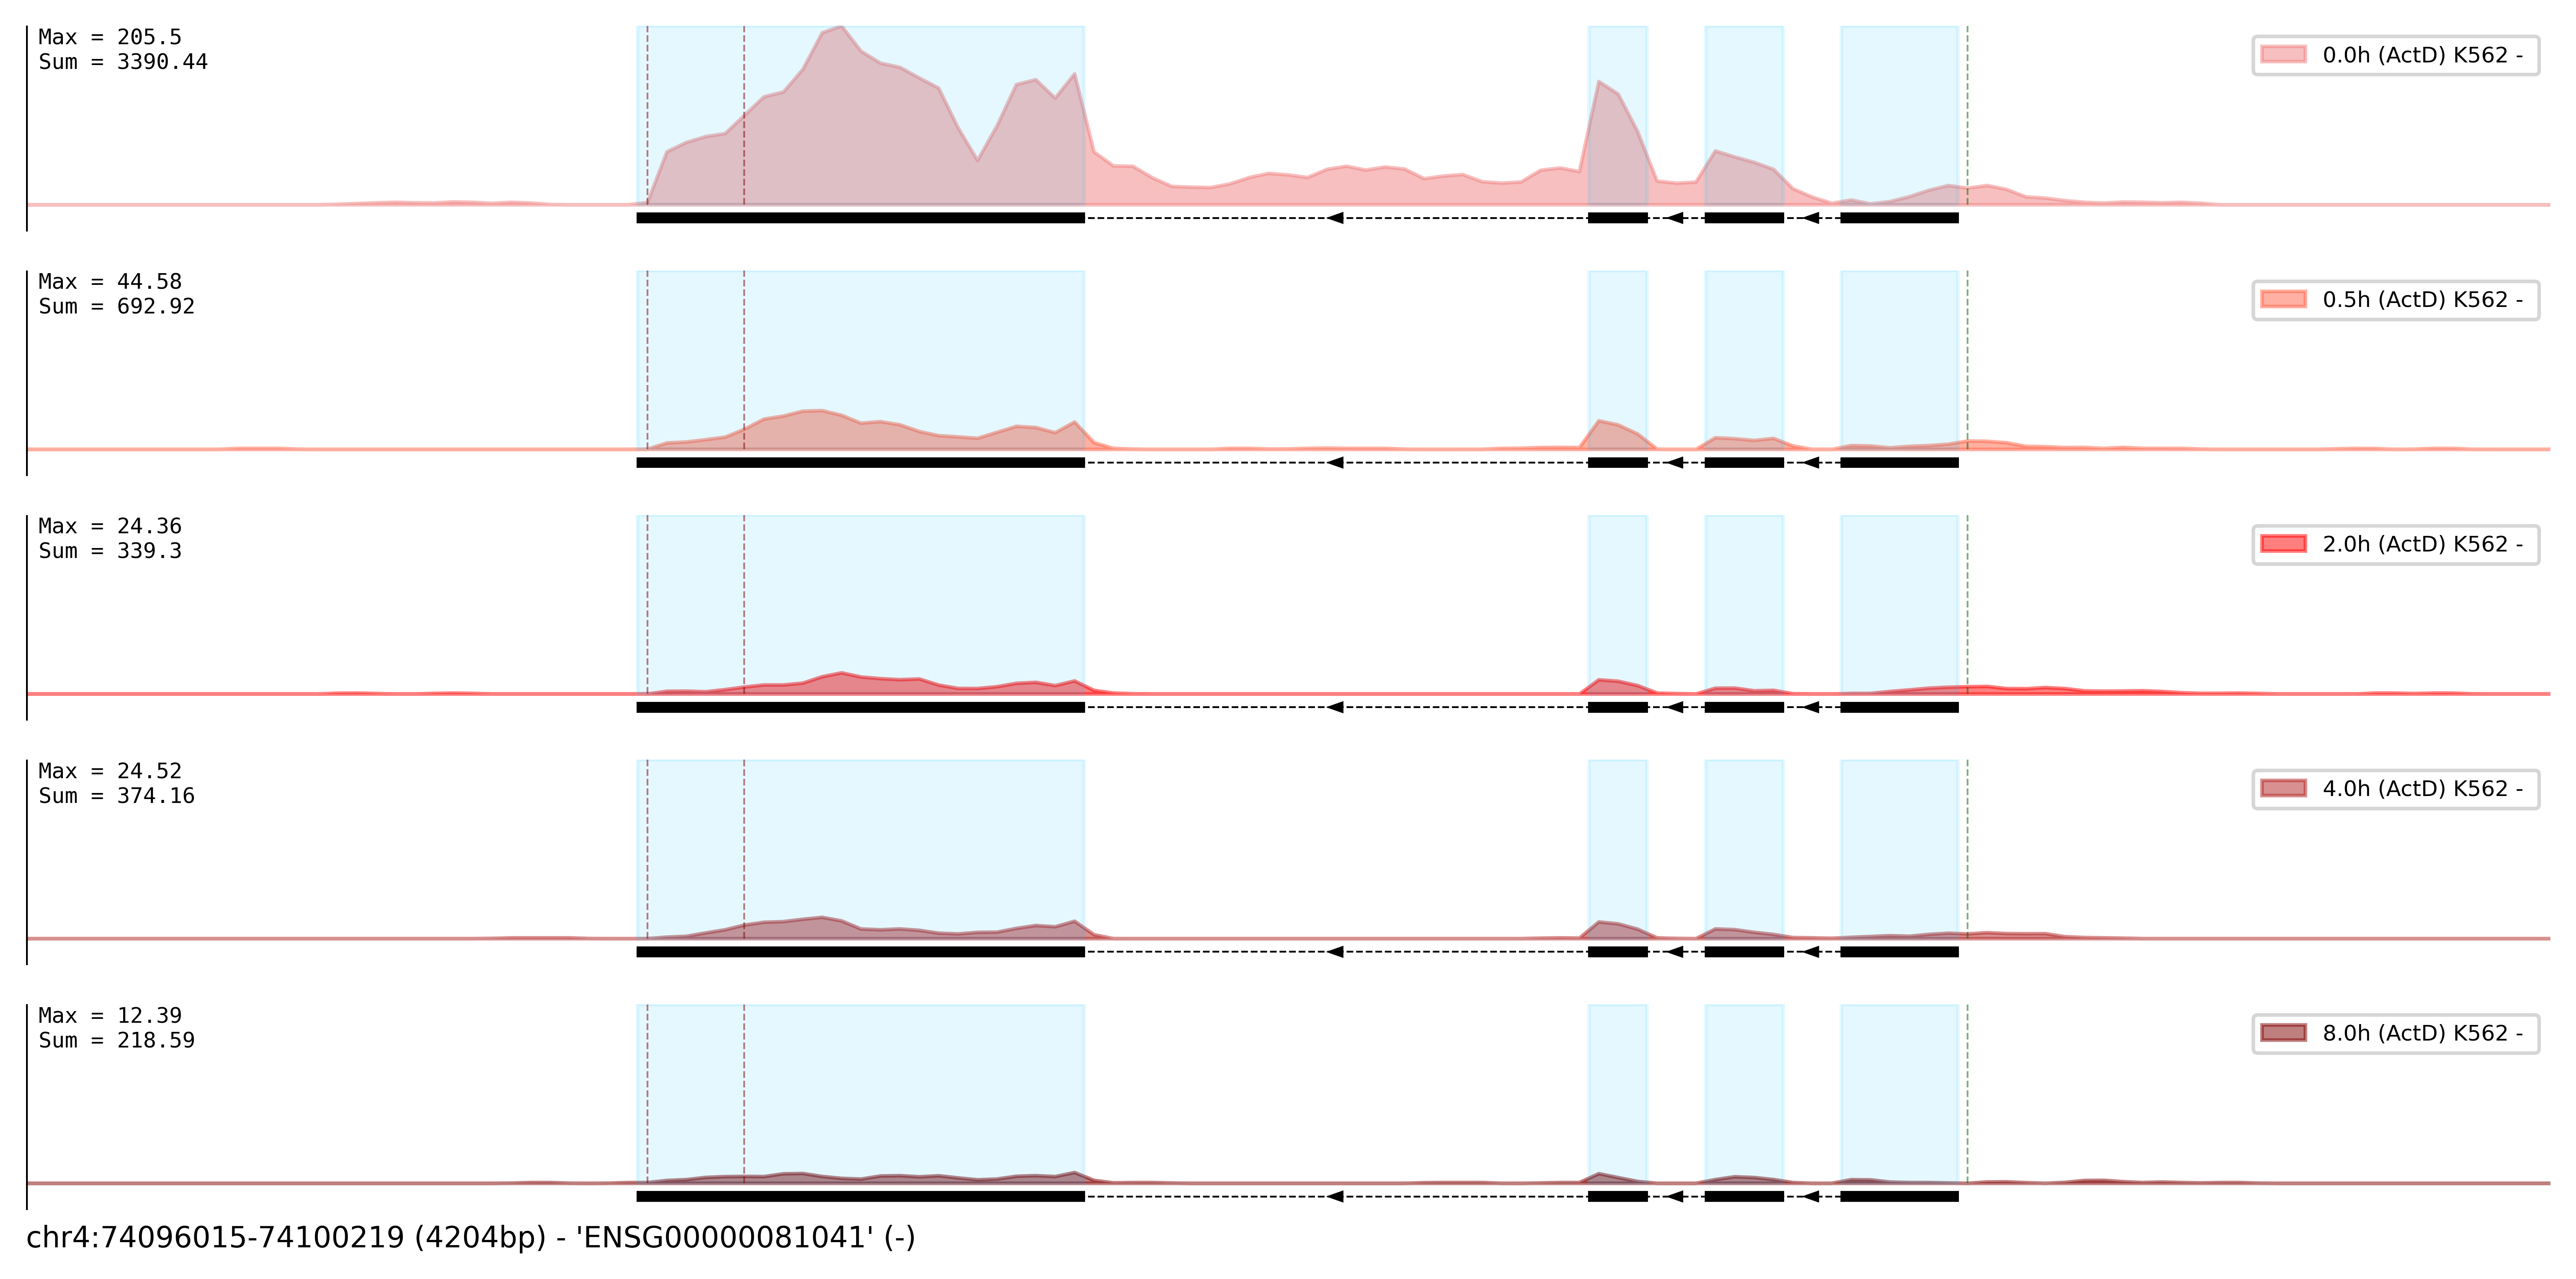

In [7]:
#Visualize quantized tracks

save_figs = True
save_suffix = '_CXCL2_RNA'

plot_start = g_start - start - 1024
plot_end = g_end - start + 1024
bin_size = 32
pad = 0

plot_measurements = True

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.5h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__2h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__4h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__8h__rep.')).values)[0].tolist(),
]

track_names = [
    '',
    '',
    '',
    '',
    '',
]

track_files = [
    targets_df.loc[targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep.')]['file'].values.tolist(),
    targets_df.loc[targets_df['description'].str.contains('RNA:ActD:K562__0\.5h__rep.')]['file'].values.tolist(),
    targets_df.loc[targets_df['description'].str.contains('RNA:ActD:K562__2h__rep.')]['file'].values.tolist(),
    targets_df.loc[targets_df['description'].str.contains('RNA:ActD:K562__4h__rep.')]['file'].values.tolist(),
    targets_df.loc[targets_df['description'].str.contains('RNA:ActD:K562__8h__rep.')]['file'].values.tolist(),
]

track_colors = [
    ['lightcoral'],
    ['tomato'],
    ['red'],
    ['firebrick'],
    ['maroon'],
]

#Normalization scales from measured GAPDH expression levels
norm_scales = np.array([
    12667.4,
    15248.4,
    16112.3,
    18526.4,
    20939.0,
])
norm_scales /= np.sum(norm_scales)

track_labels = [
    ['0.0h (ActD) K562'],
    ['0.5h (ActD) K562'],
    ['2.0h (ActD) K562'],
    ['4.0h (ActD) K562'],
    ['8.0h (ActD) K562'],
]

track_scale = 1.#0.02
track_transform = 1./2.
soft_clip = 384.

print("--- Predicted (Borzoi) ---")

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=np.zeros(y_wt.shape),
    norm_scales=norm_scales,
    plot_pair=False,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    normalize_counts=False,
    normalize_start_rel=0,
    normalize_end_rel=393216,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=[],
    isoform_slices=[],
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=[],
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=False,
)

if plot_measurements :
    
    track_scale = 1.#0.02
    track_transform = 1./2.
    soft_clip = 384.
    
    y_meas = []
    track_indices_meas = []
    
    track_i = 0
    for cov_files in track_files :
        
        read_coverage_func, close_coverage_func = get_coverage_reader(cov_files, 12288, pad * bin_size, '/home/jlinder/borzoi/examples/hg38/blacklist/blacklist_hg38_all.bed')
        cov_targets = read_coverage_func(chrom, start, end, clip_soft=soft_clip, clip=384., scale=0.02, transform_old=False)
        close_coverage_func()
        
        y_meas.append(cov_targets[None, None, ...])
        
        track_index = []
        for j in range(len(cov_files)) :
            track_index.append(track_i)
            track_i += 1
        
        track_indices_meas.append(track_index)
    
    y_meas = np.concatenate(y_meas, axis=-1)
    
    print("--- Measured ---")

    #Plot coverage
    plot_coverage_tracks(
        y_meas,
        track_indices_meas,
        track_names,
        track_colors,
        track_labels,
        track_scale,
        track_transform,
        soft_clip,
        start,
        y_2_in=np.zeros(y_meas.shape),
        norm_scales=norm_scales,
        plot_pair=False,
        log_scale=False,
        same_scale=True,
        plot_start_rel=plot_start,
        plot_end_rel=plot_end,
        bin_size=bin_size,
        pad=pad,
        normalize_counts=False,
        normalize_start_rel=0,
        normalize_end_rel=393216,
        highlight_covr_poses_rel=highlight_covr_poses_rel,
        covr_orientation=covr_orientation,
        covr_agg=covr_agg,
        covr_width=covr_width,
        save_figs=save_figs,
        save_suffix=save_suffix + '_meas',
        gene_slice=gene_slice,
        gene_slices=[],
        isoform_slices=[],
        gene_strand=gene_strand,
        chrom=chrom,
        search_gene=search_gene,
        gene_strands=[],
        apa_df_gene_utr=apa_df_gene_utr,
        apa_df_gene_intron=apa_df_gene_intron,
        tss_df_gene=tss_df_gene,
        annotate_utr_apa=True,
        annotate_intron_apa=True,
        annotate_tss=True,
        plot_strands=True,
        plot_other_genes=False,
        plot_other_gene_strands=False,
        plot_isoforms=False,
        plot_isoform_strands=False,
        gene_color='black',
        isoform_color='dimgray',
        other_gene_color='black',
        max_isoforms=5,
        isoform_height_frac=0.,
        plot_as_bars=False,
        fig_size=(10, 1),
        untransform_old=False,
    )


--- Predicted (Borzoi) ---


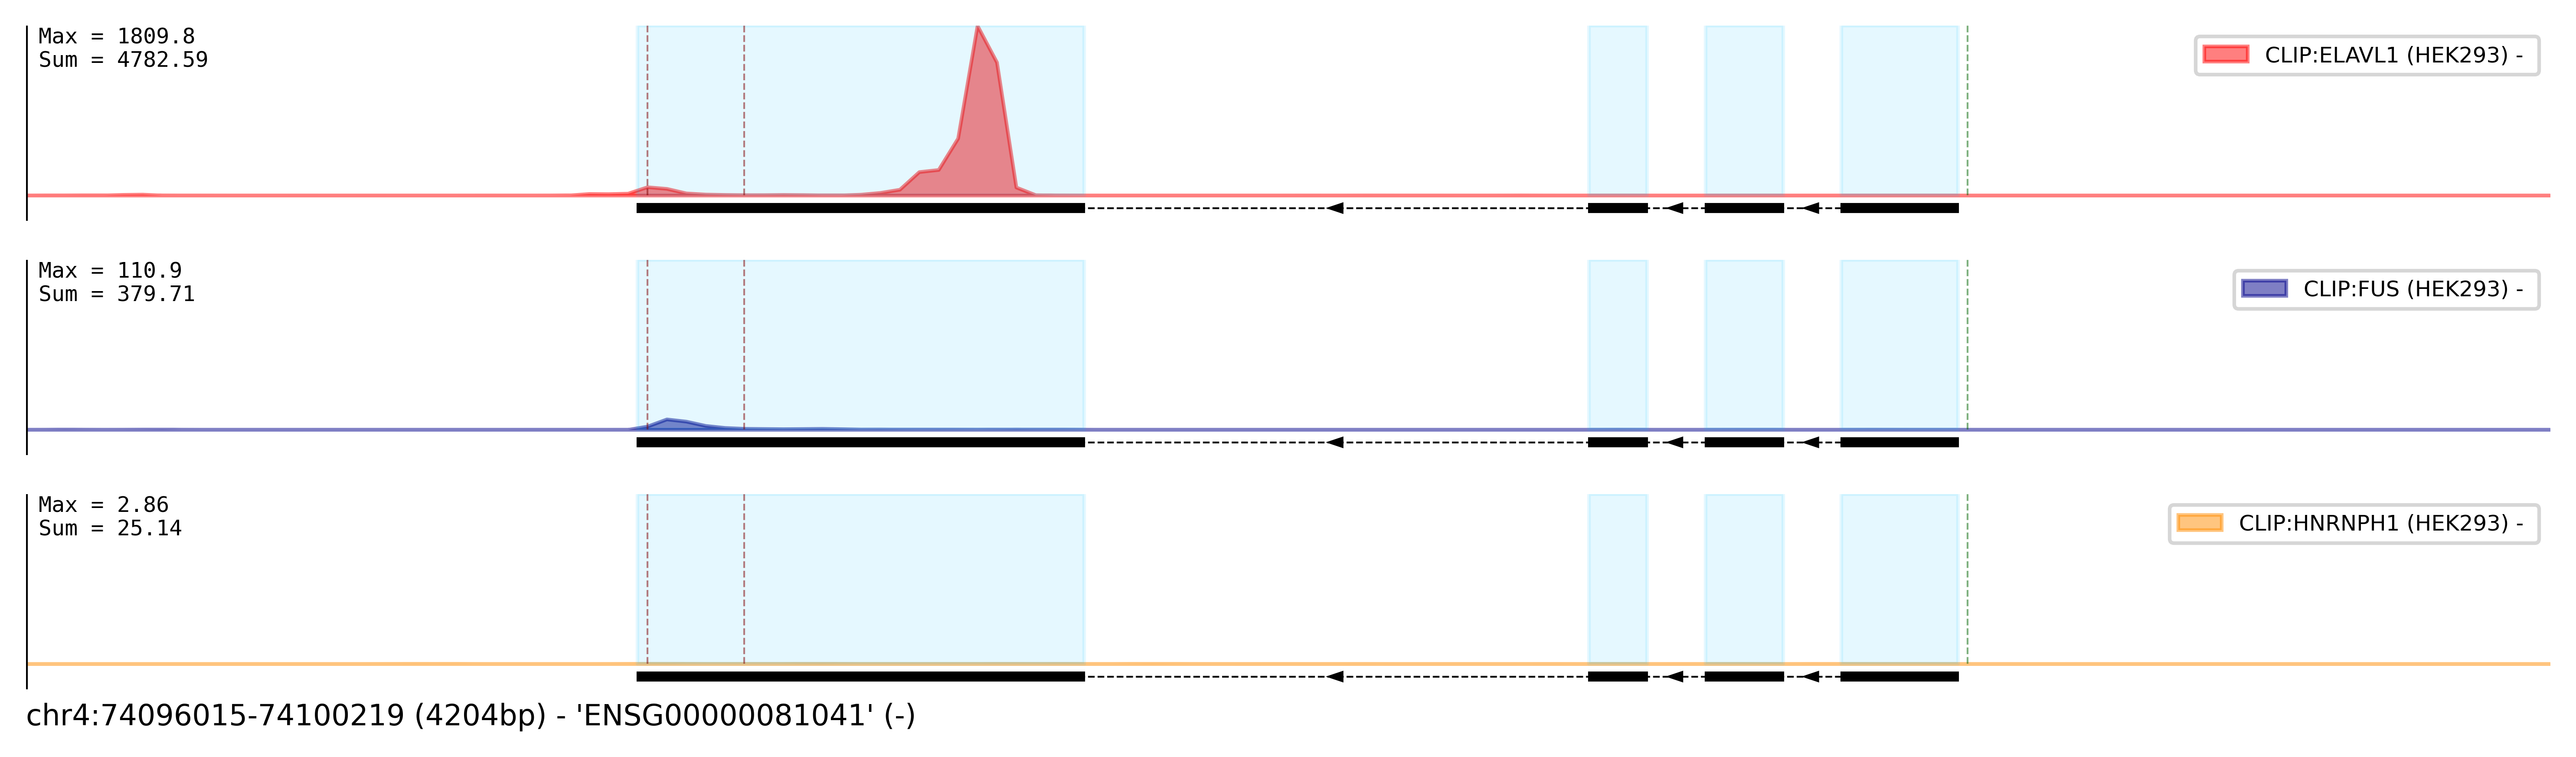

--- Measured ---


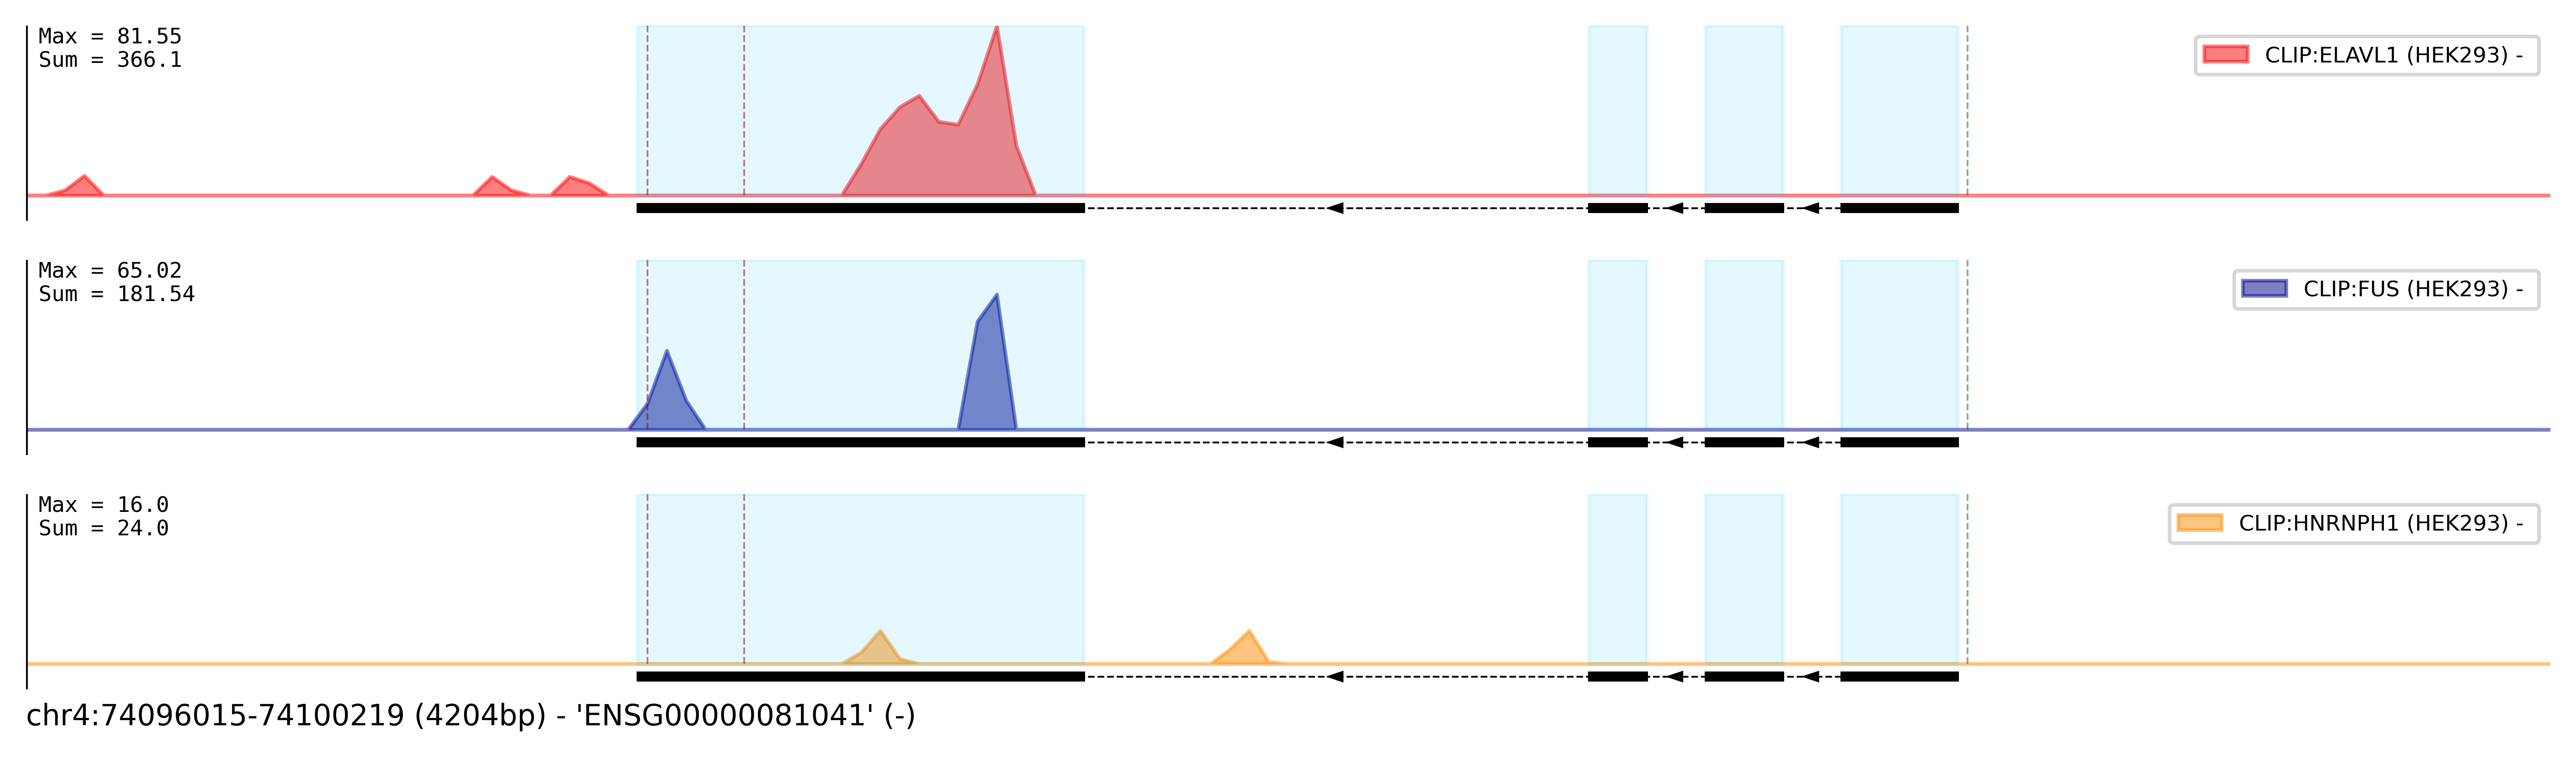

In [8]:
#Visualize quantized tracks

save_figs = True
save_suffix = '_CXCL2_CLIP_goodarzi'

plot_start = g_start - start - 1024
plot_end = g_end - start + 1024
bin_size = 32
pad = 0

plot_measurements = True

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero(((targets_df['description'] == 'CLIP:ELAVL1 (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:FUS (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:HNRNPH1 (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
]

track_names = [
    '',
    '',
    '',
]

track_files = [
    targets_df.loc[(targets_df['description'] == 'CLIP:ELAVL1 (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:FUS (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:HNRNPH1 (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
]

track_colors = [
    ['red'],
    ['darkblue'],
    ['darkorange'],
]

track_labels = [
    ['CLIP:ELAVL1 (HEK293)'],
    ['CLIP:FUS (HEK293)'],
    ['CLIP:HNRNPH1 (HEK293)'],
]

track_scale = 1.#0.5
track_transform = 1./2.
soft_clip = 384.

print("--- Predicted (Borzoi) ---")

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=np.zeros(y_wt.shape),
    plot_pair=False,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    normalize_counts=False,
    normalize_start_rel=0,
    normalize_end_rel=393216,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=[],
    isoform_slices=[],
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=[],
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=False,
)

if plot_measurements :
    
    track_scale = 1.#0.5
    track_transform = 1./2.
    soft_clip = 384.
    
    y_meas = []
    track_indices_meas = []
    
    track_i = 0
    for cov_files in track_files :
        
        read_coverage_func, close_coverage_func = get_coverage_reader(cov_files, 12288, pad * bin_size, '/home/jlinder/borzoi/examples/hg38/blacklist/blacklist_hg38_all.bed')
        cov_targets = read_coverage_func(chrom, start, end, clip_soft=384., clip=768., scale=0.5, transform_old=False)
        close_coverage_func()
        
        y_meas.append(cov_targets[None, None, ...])
        
        track_index = []
        for j in range(len(cov_files)) :
            track_index.append(track_i)
            track_i += 1
        
        track_indices_meas.append(track_index)
    
    y_meas = np.concatenate(y_meas, axis=-1)
    
    print("--- Measured ---")

    #Plot coverage
    plot_coverage_tracks(
        y_meas,
        track_indices_meas,
        track_names,
        track_colors,
        track_labels,
        track_scale,
        track_transform,
        soft_clip,
        start,
        y_2_in=np.zeros(y_meas.shape),
        plot_pair=False,
        log_scale=False,
        same_scale=True,
        plot_start_rel=plot_start,
        plot_end_rel=plot_end,
        bin_size=bin_size,
        pad=pad,
        normalize_counts=False,
        normalize_start_rel=0,
        normalize_end_rel=393216,
        highlight_covr_poses_rel=highlight_covr_poses_rel,
        covr_orientation=covr_orientation,
        covr_agg=covr_agg,
        covr_width=covr_width,
        save_figs=save_figs,
        save_suffix=save_suffix + '_meas',
        gene_slice=gene_slice,
        gene_slices=[],
        isoform_slices=[],
        gene_strand=gene_strand,
        chrom=chrom,
        search_gene=search_gene,
        gene_strands=[],
        apa_df_gene_utr=apa_df_gene_utr,
        apa_df_gene_intron=apa_df_gene_intron,
        tss_df_gene=tss_df_gene,
        annotate_utr_apa=True,
        annotate_intron_apa=True,
        annotate_tss=True,
        plot_strands=True,
        plot_other_genes=False,
        plot_other_gene_strands=False,
        plot_isoforms=False,
        plot_isoform_strands=False,
        gene_color='black',
        isoform_color='dimgray',
        other_gene_color='black',
        max_isoforms=5,
        isoform_height_frac=0.,
        plot_as_bars=False,
        fig_size=(10, 1),
        untransform_old=False,
    )


--- Predicted (Borzoi) ---


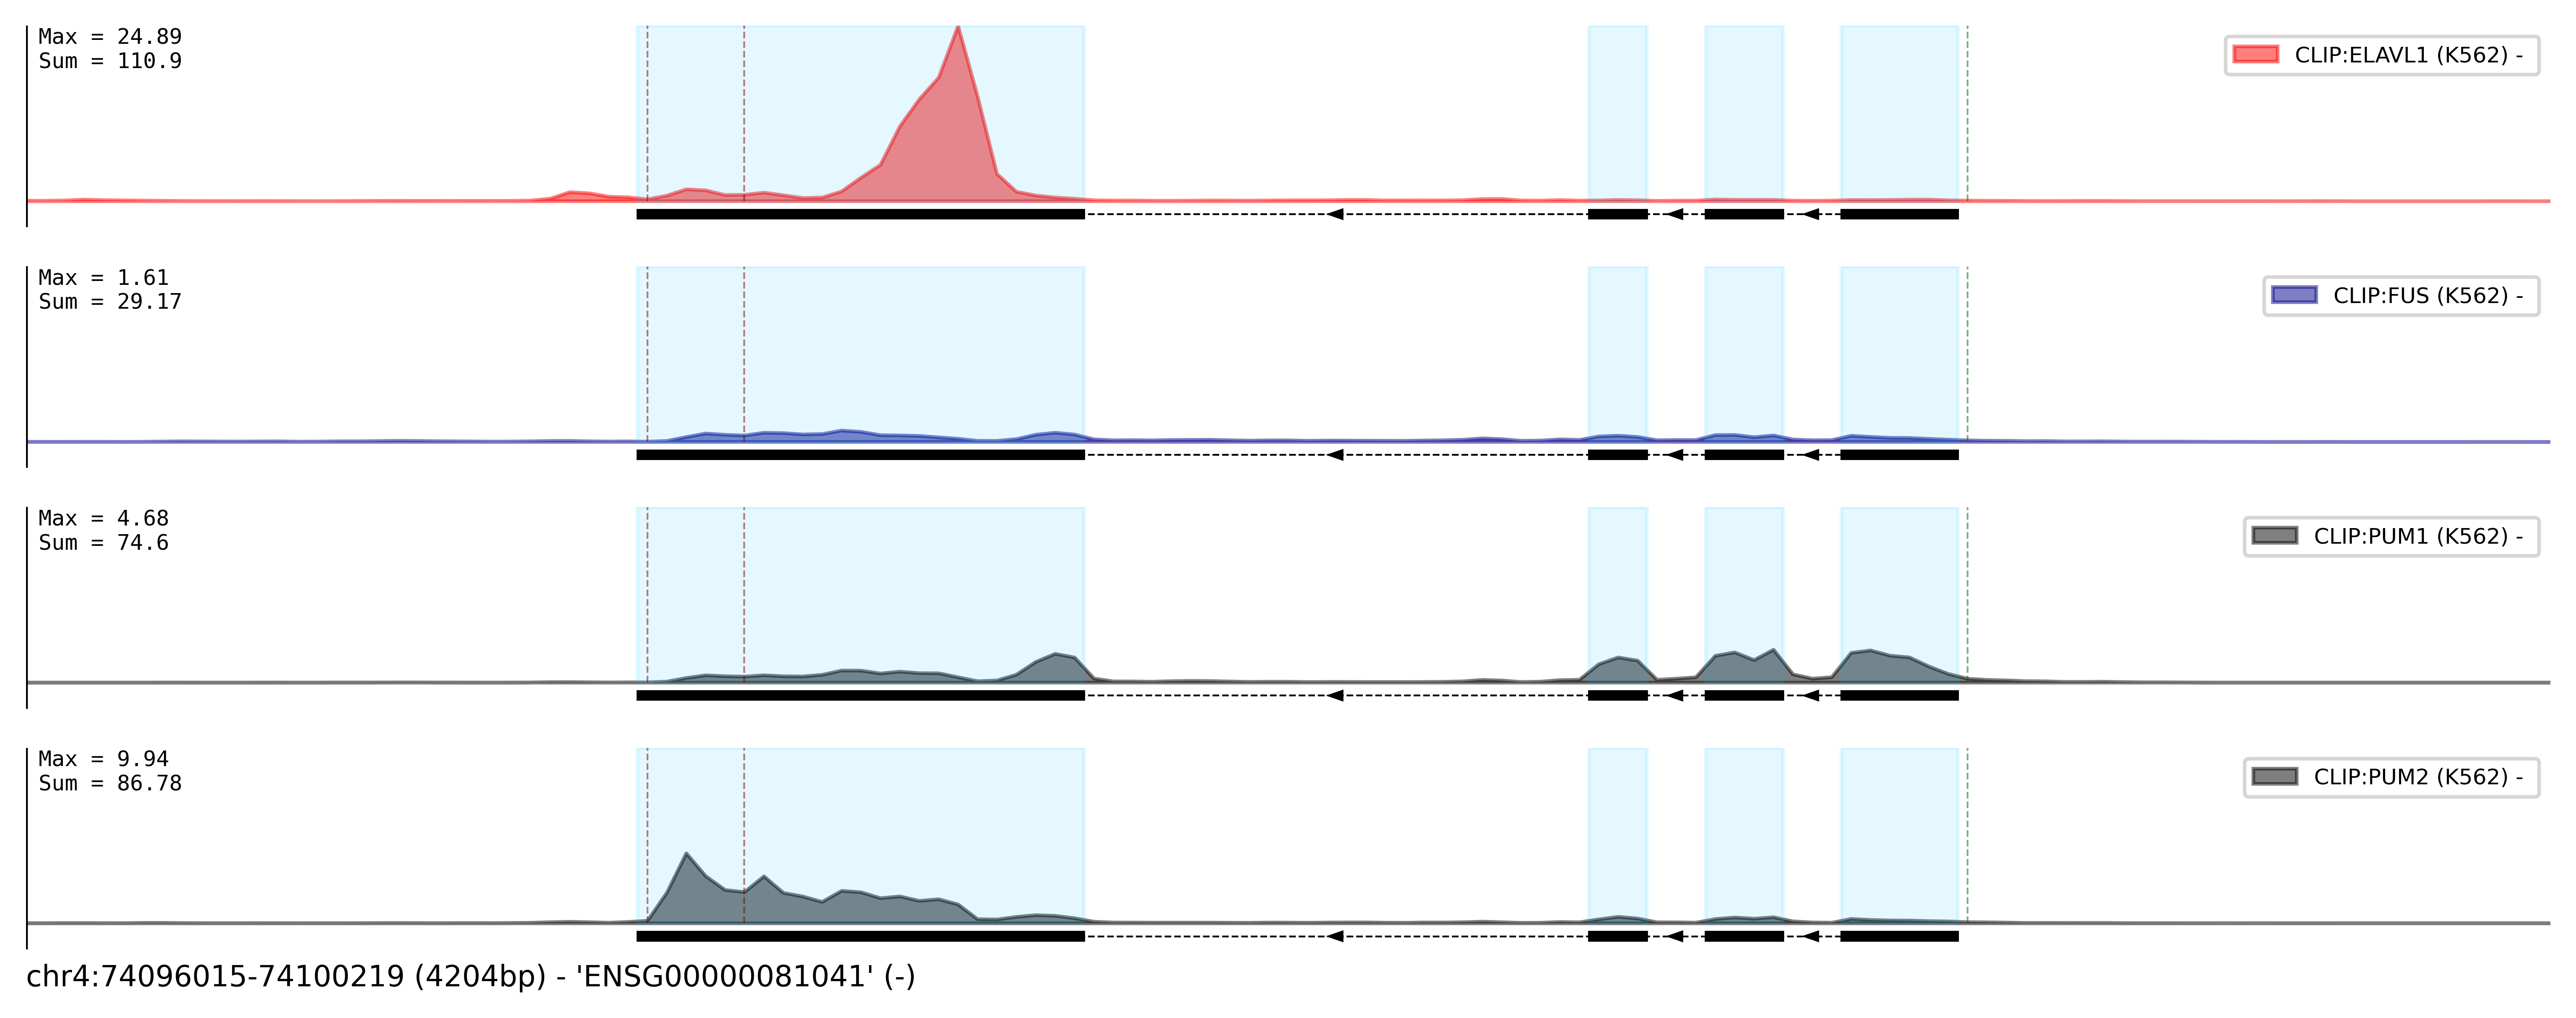

--- Measured ---


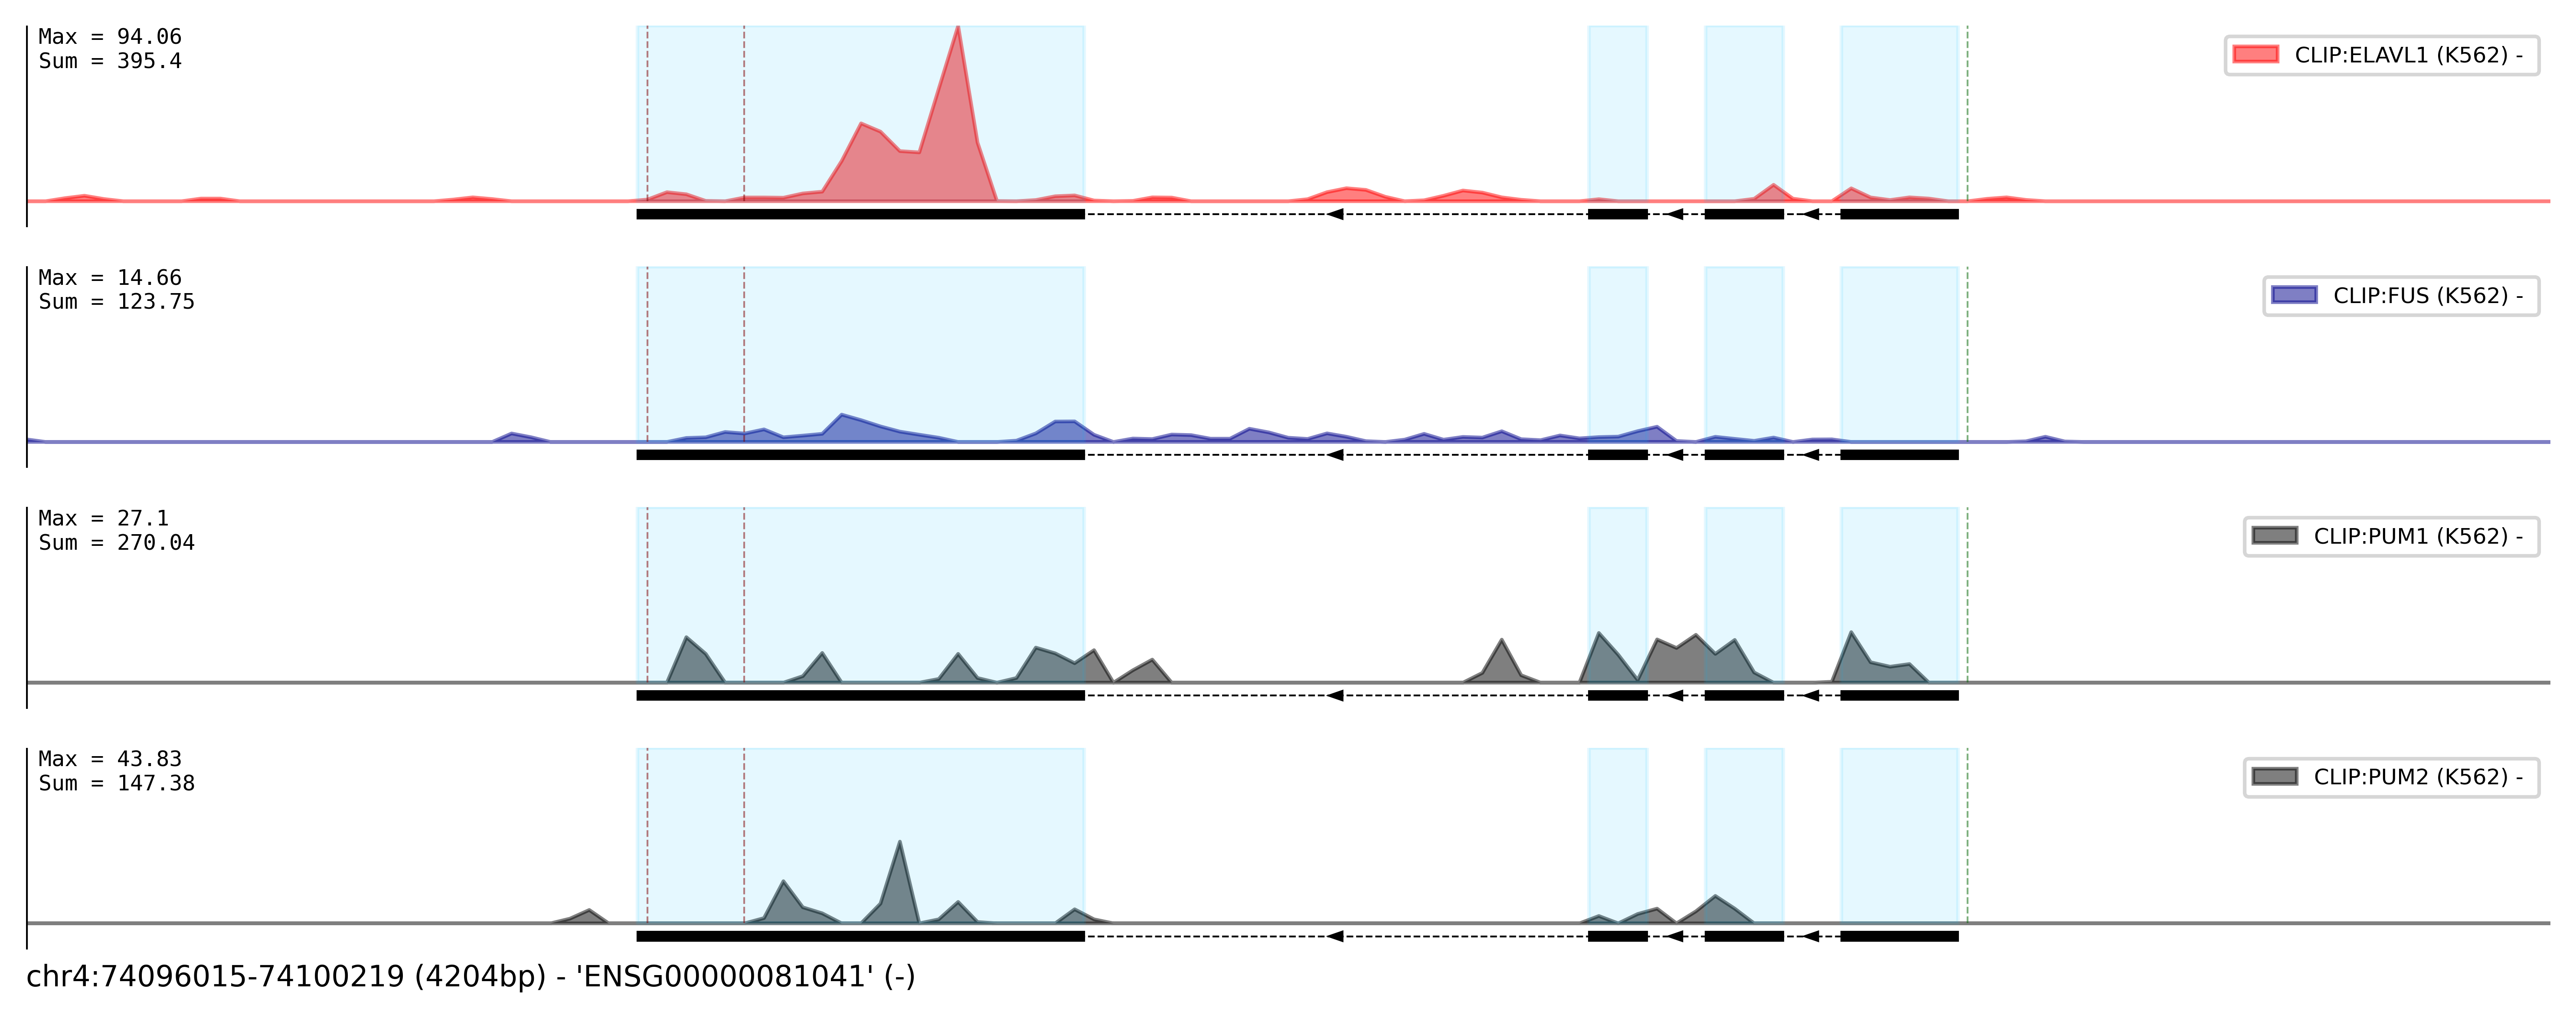

In [9]:
#Visualize quantized tracks

save_figs = True
save_suffix = '_CXCL2_CLIP_encode'

plot_start = g_start - start - 1024
plot_end = g_end - start + 1024
bin_size = 32
pad = 0

plot_measurements = True

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero(((targets_df['description'] == 'CLIP:ELAVL1:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:FUS:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:PUM1:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:PUM2:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
]

track_names = [
    '',
    '',
    '',
    '',
]

track_files = [
    targets_df.loc[(targets_df['description'] == 'CLIP:ELAVL1:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:FUS:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:PUM1:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:PUM2:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
]

track_colors = [
    ['red'],
    ['darkblue'],
    ['black'],
    ['black'],
]

track_labels = [
    ['CLIP:ELAVL1 (K562)'],
    ['CLIP:FUS (K562)'],
    ['CLIP:PUM1 (K562)'],
    ['CLIP:PUM2 (K562)'],
]

track_scale = 1.#2.0
track_transform = 1./2.
soft_clip = 384.

print("--- Predicted (Borzoi) ---")

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=np.zeros(y_wt.shape),
    plot_pair=False,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    normalize_counts=False,
    normalize_start_rel=0,
    normalize_end_rel=393216,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=[],
    isoform_slices=[],
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=[],
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=False,
)

if plot_measurements :
    
    track_scale = 1.#2.0
    track_transform = 1./2.
    soft_clip = 384.
    
    y_meas = []
    track_indices_meas = []
    
    track_i = 0
    for cov_files in track_files :
        
        read_coverage_func, close_coverage_func = get_coverage_reader(cov_files, 12288, pad * bin_size, '/home/jlinder/borzoi/examples/hg38/blacklist/blacklist_hg38_all.bed')
        cov_targets = read_coverage_func(chrom, start, end, clip_soft=384., clip=384., scale=2.0, transform_old=False)
        close_coverage_func()
        
        y_meas.append(cov_targets[None, None, ...])
        
        track_index = []
        for j in range(len(cov_files)) :
            track_index.append(track_i)
            track_i += 1
        
        track_indices_meas.append(track_index)
    
    y_meas = np.concatenate(y_meas, axis=-1)
    
    print("--- Measured ---")

    #Plot coverage
    plot_coverage_tracks(
        y_meas,
        track_indices_meas,
        track_names,
        track_colors,
        track_labels,
        track_scale,
        track_transform,
        soft_clip,
        start,
        y_2_in=np.zeros(y_meas.shape),
        plot_pair=False,
        log_scale=False,
        same_scale=True,
        plot_start_rel=plot_start,
        plot_end_rel=plot_end,
        bin_size=bin_size,
        pad=pad,
        normalize_counts=False,
        normalize_start_rel=0,
        normalize_end_rel=393216,
        highlight_covr_poses_rel=highlight_covr_poses_rel,
        covr_orientation=covr_orientation,
        covr_agg=covr_agg,
        covr_width=covr_width,
        save_figs=save_figs,
        save_suffix=save_suffix + '_meas',
        gene_slice=gene_slice,
        gene_slices=[],
        isoform_slices=[],
        gene_strand=gene_strand,
        chrom=chrom,
        search_gene=search_gene,
        gene_strands=[],
        apa_df_gene_utr=apa_df_gene_utr,
        apa_df_gene_intron=apa_df_gene_intron,
        tss_df_gene=tss_df_gene,
        annotate_utr_apa=True,
        annotate_intron_apa=True,
        annotate_tss=True,
        plot_strands=True,
        plot_other_genes=False,
        plot_other_gene_strands=False,
        plot_isoforms=False,
        plot_isoform_strands=False,
        gene_color='black',
        isoform_color='dimgray',
        other_gene_color='black',
        max_isoforms=5,
        isoform_height_frac=0.,
        plot_as_bars=False,
        fig_size=(10, 1),
        untransform_old=False,
    )


In [12]:
#Randomly mutate AT stretch

n_samples = 32

y_muts = []
for sample_ix in range(n_samples) :
    
    print("sample_ix = " + str(sample_ix))
    
    #Get mut sequence
    seq_1hot_mut = np.copy(seq_1hot_wt)

    seq_1hot_mut[196076:196104, :] = 0.
    for j in range(196076, 196104) :
        seq_1hot_mut[j, np.random.choice([0, 1, 2, 3], p=[0.20, 0.30, 0.30, 0.20])] = 1.

    #Make mut prediction
    y_mut = predict_tracks(models if model_subset is None or len(model_subset) == 0 else model_subset, seq_1hot_mut)
    y_muts.append(y_mut[None, :])

y_mut = np.mean(np.concatenate(y_muts, axis=0), axis=0)

print("y_mut.shape = " + str(y_mut.shape))


sample_ix = 0
sample_ix = 1
sample_ix = 2
sample_ix = 3
sample_ix = 4
sample_ix = 5
sample_ix = 6
sample_ix = 7
sample_ix = 8
sample_ix = 9
sample_ix = 10
sample_ix = 11
sample_ix = 12
sample_ix = 13
sample_ix = 14
sample_ix = 15
sample_ix = 16
sample_ix = 17
sample_ix = 18
sample_ix = 19
sample_ix = 20
sample_ix = 21
sample_ix = 22
sample_ix = 23
sample_ix = 24
sample_ix = 25
sample_ix = 26
sample_ix = 27
sample_ix = 28
sample_ix = 29
sample_ix = 30
sample_ix = 31
y_mut.shape = (1, 2, 12288, 452)


--- Predicted (Borzoi) ---


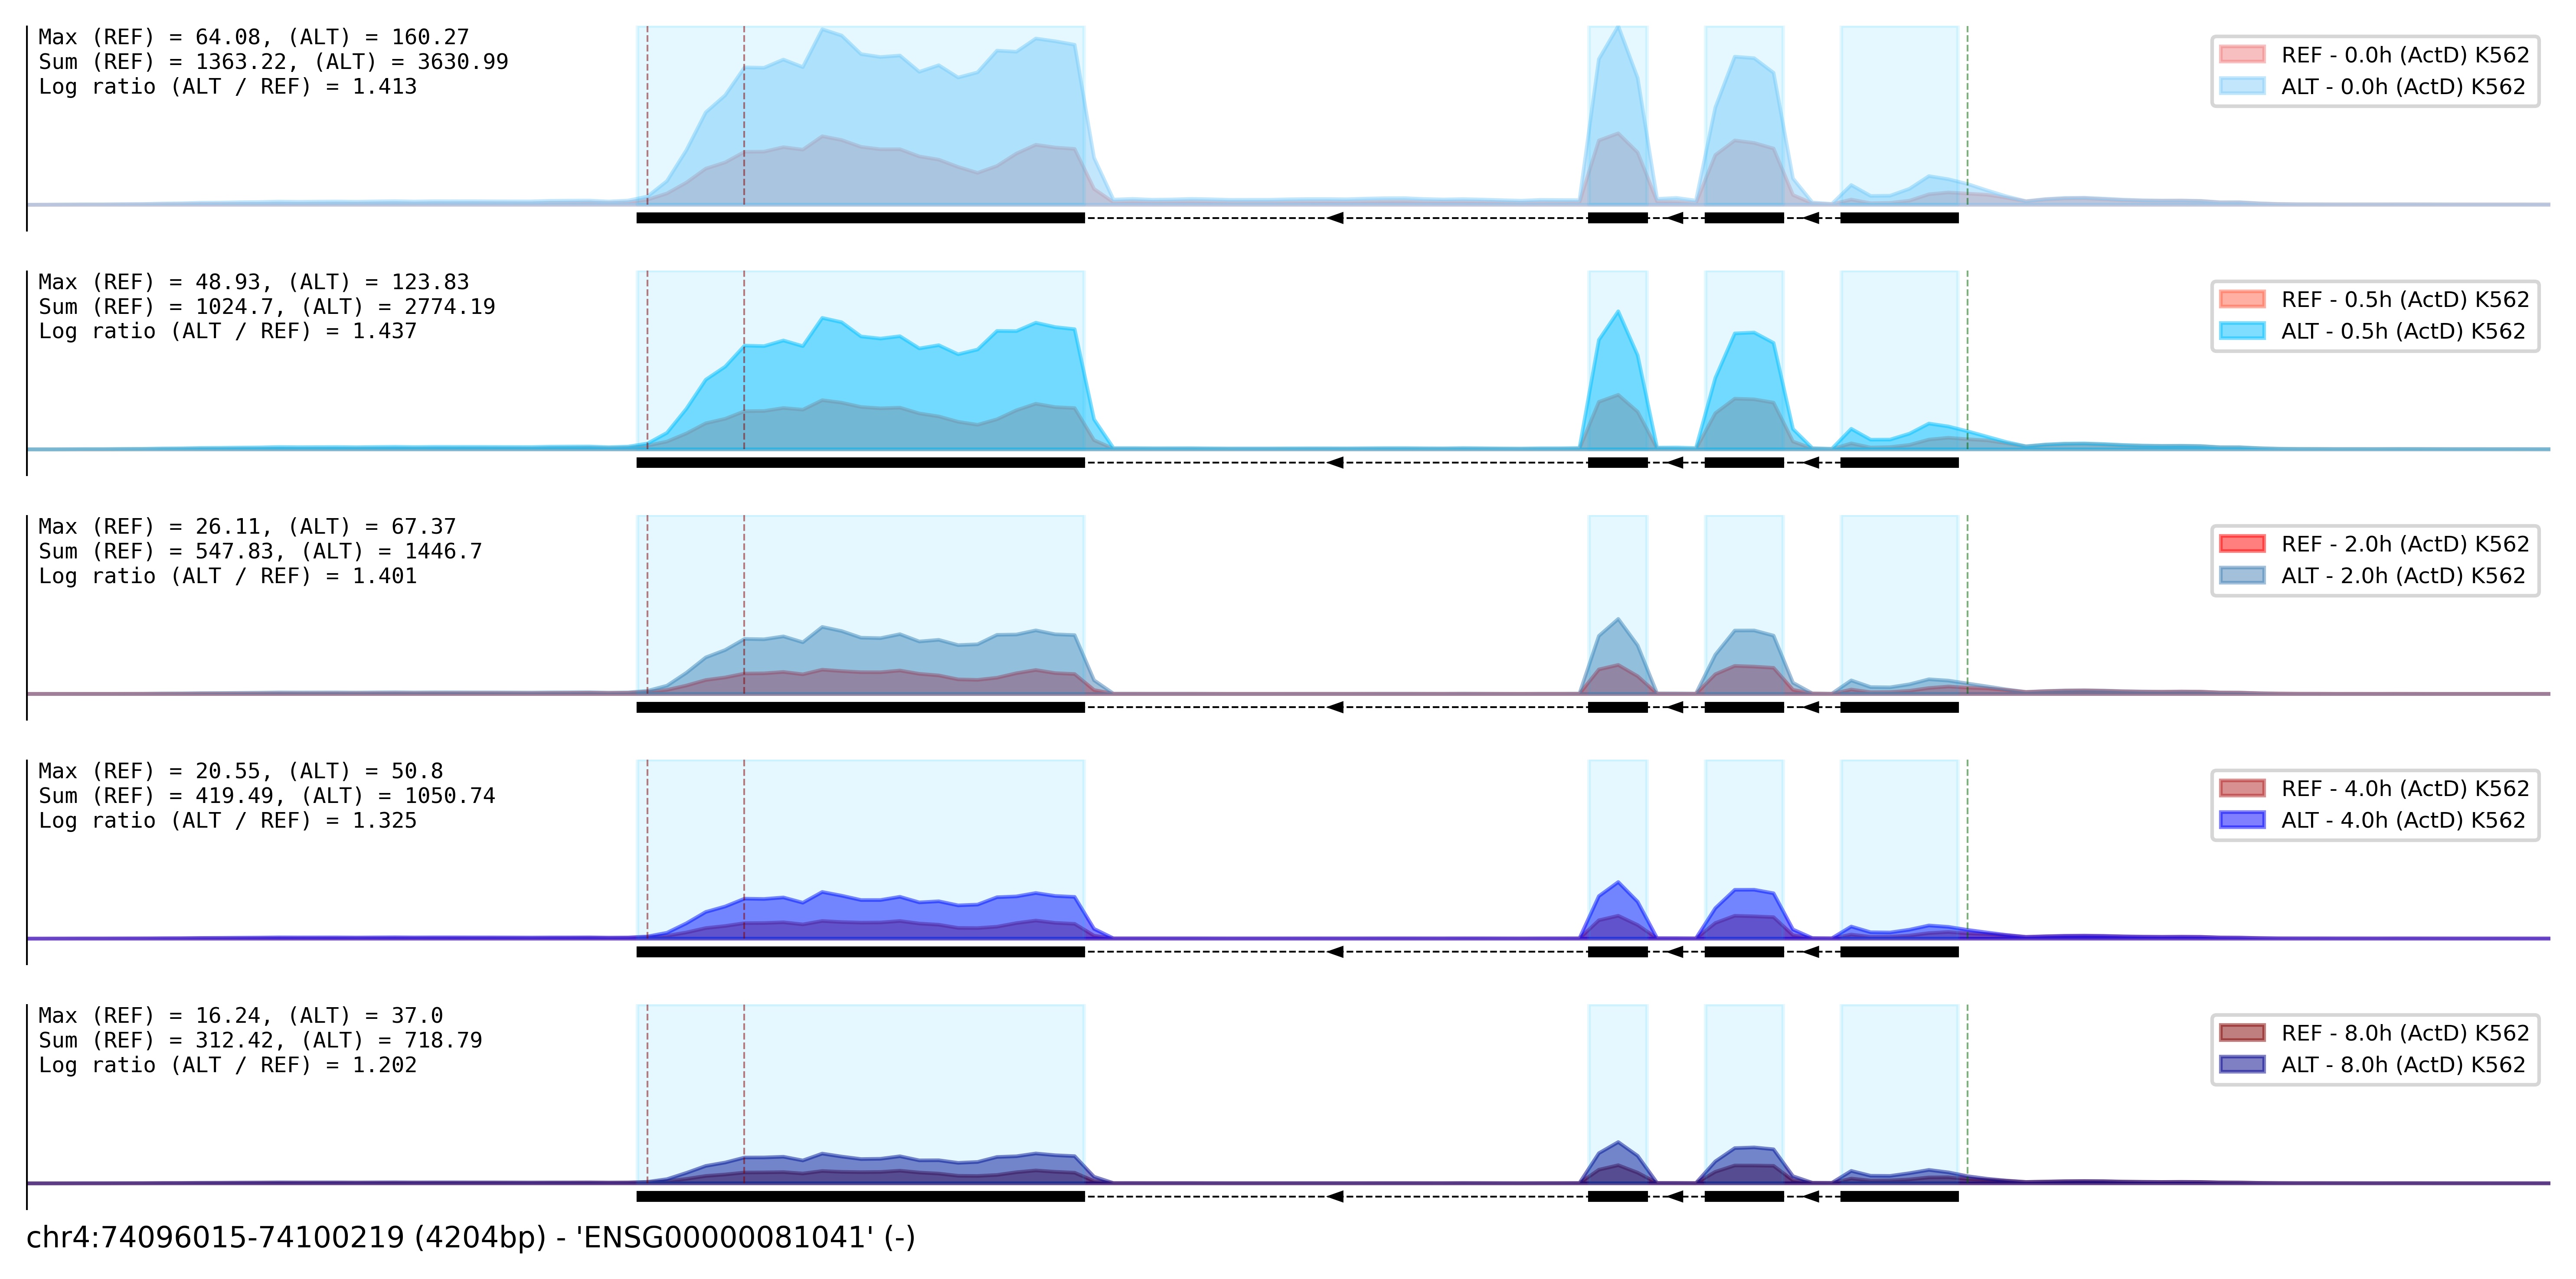

In [13]:
#Visualize quantized tracks

save_figs = True
save_suffix = '_CXCL2_RNA_shuffle'

plot_start = g_start - start - 1024
plot_end = g_end - start + 1024
bin_size = 32
pad = 0

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.5h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__2h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__4h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__8h__rep.')).values)[0].tolist(),
]

track_names = [
    '0.0h (ActD) K562',
    '0.5h (ActD) K562',
    '2.0h (ActD) K562',
    '4.0h (ActD) K562',
    '8.0h (ActD) K562',
]

track_colors = [
    ['lightcoral', 'lightskyblue'],
    ['tomato', 'deepskyblue'],
    ['red', 'steelblue'],
    ['firebrick', 'blue'],
    ['maroon', 'darkblue'],
]

norm_scales = np.array([
    12667.4,
    15248.4,
    16112.3,
    18526.4,
    20939.0,
])
norm_scales /= np.sum(norm_scales)

track_labels = [
    ['REF', 'ALT'],
    ['REF', 'ALT'],
    ['REF', 'ALT'],
    ['REF', 'ALT'],
    ['REF', 'ALT'],
]

track_scale = 1.#0.02
track_transform = 1./2.
soft_clip = 384.

print("--- Predicted (Borzoi) ---")

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    norm_scales=norm_scales,
    plot_pair=True,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    normalize_counts=False,
    normalize_start_rel=0,
    normalize_end_rel=393216,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=[],
    isoform_slices=[],
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=[],
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=False,
)


--- Predicted (Borzoi) ---


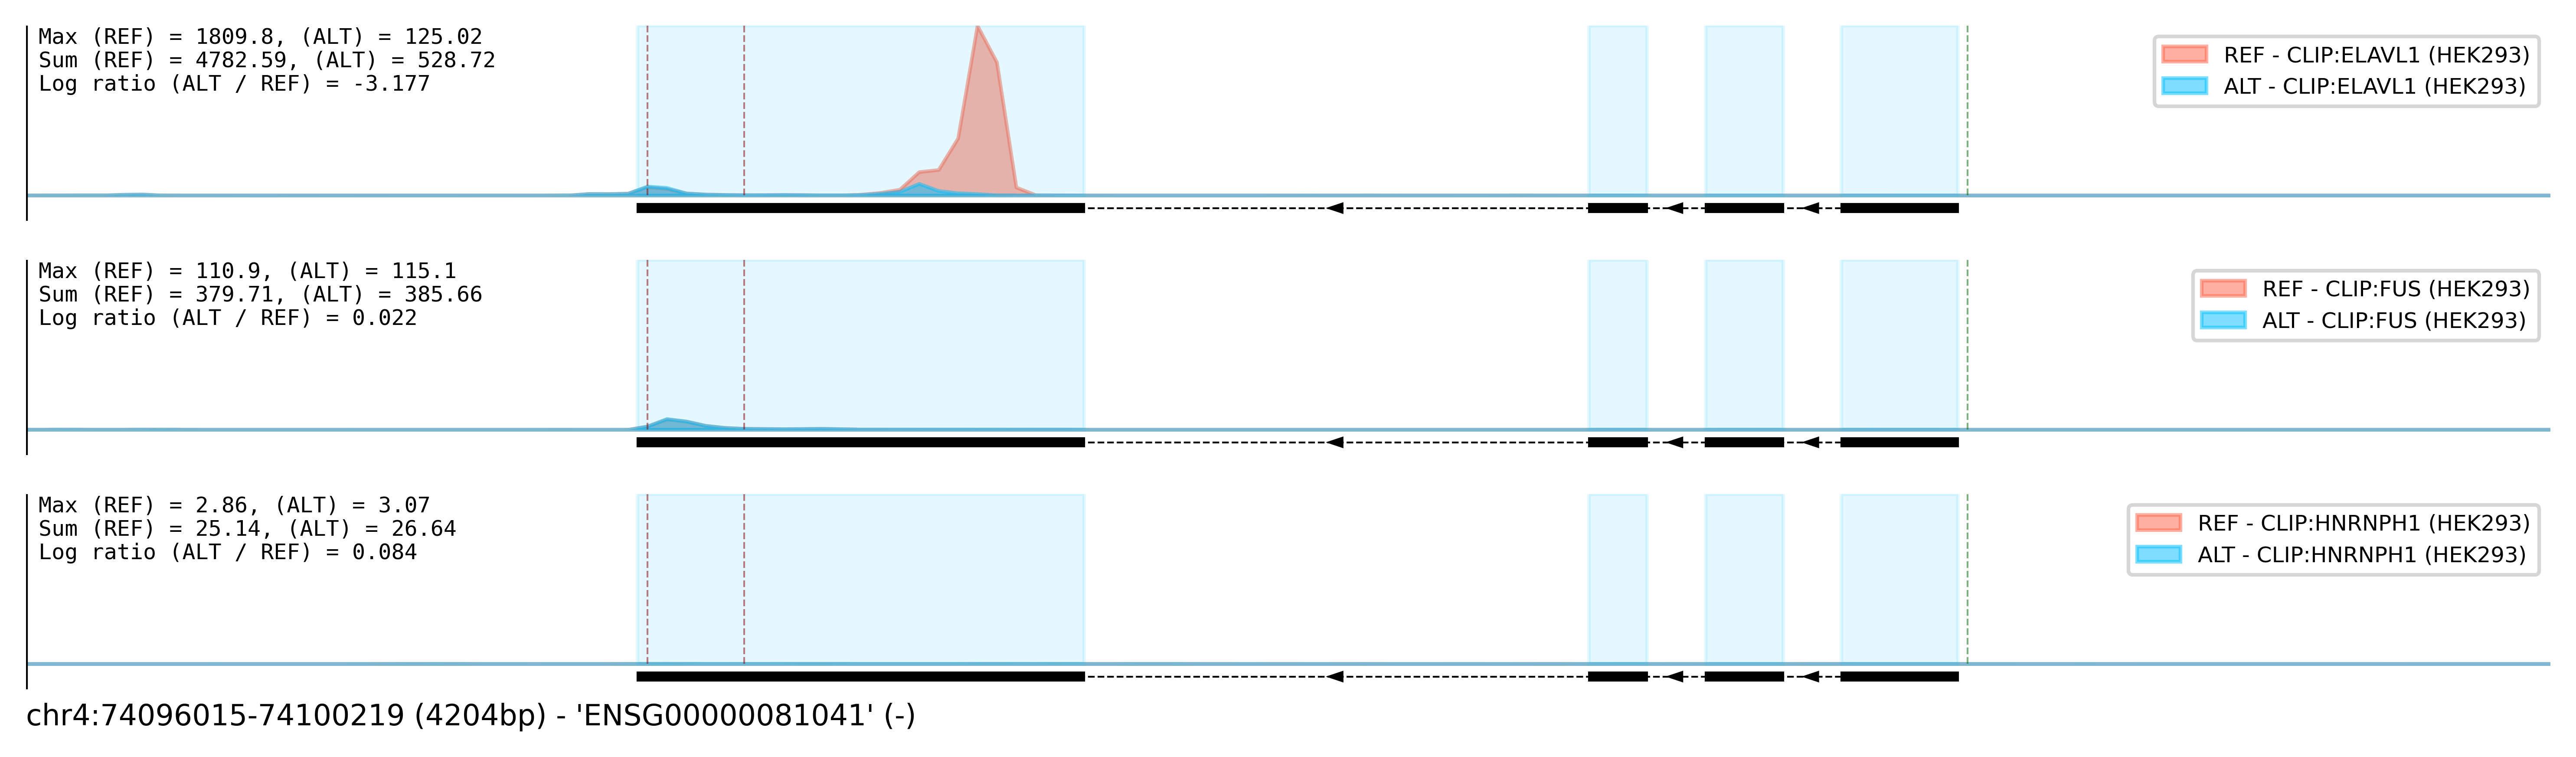

In [15]:
#Visualize quantized tracks

save_figs = True
save_suffix = '_CXCL2_CLIP_goodarzi_shuffle'

plot_start = g_start - start - 1024
plot_end = g_end - start + 1024
bin_size = 32
pad = 0

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero(((targets_df['description'] == 'CLIP:ELAVL1 (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:FUS (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:HNRNPH1 (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
]

track_names = [
    'CLIP:ELAVL1 (HEK293)',
    'CLIP:FUS (HEK293)',
    'CLIP:HNRNPH1 (HEK293)',
]

track_files = [
    targets_df.loc[(targets_df['description'] == 'CLIP:ELAVL1 (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:FUS (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:HNRNPH1 (HEK293)') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
]

track_colors = [
    ['tomato', 'deepskyblue'],
    ['tomato', 'deepskyblue'],
    ['tomato', 'deepskyblue'],
]

track_labels = [
    ['REF', 'ALT'],
    ['REF', 'ALT'],
    ['REF', 'ALT'],
]

track_scale = 1.#0.5
track_transform = 1./2.
soft_clip = 384.

print("--- Predicted (Borzoi) ---")

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    normalize_counts=False,
    normalize_start_rel=0,
    normalize_end_rel=393216,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=[],
    isoform_slices=[],
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=[],
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=False,
)


--- Predicted (Borzoi) ---


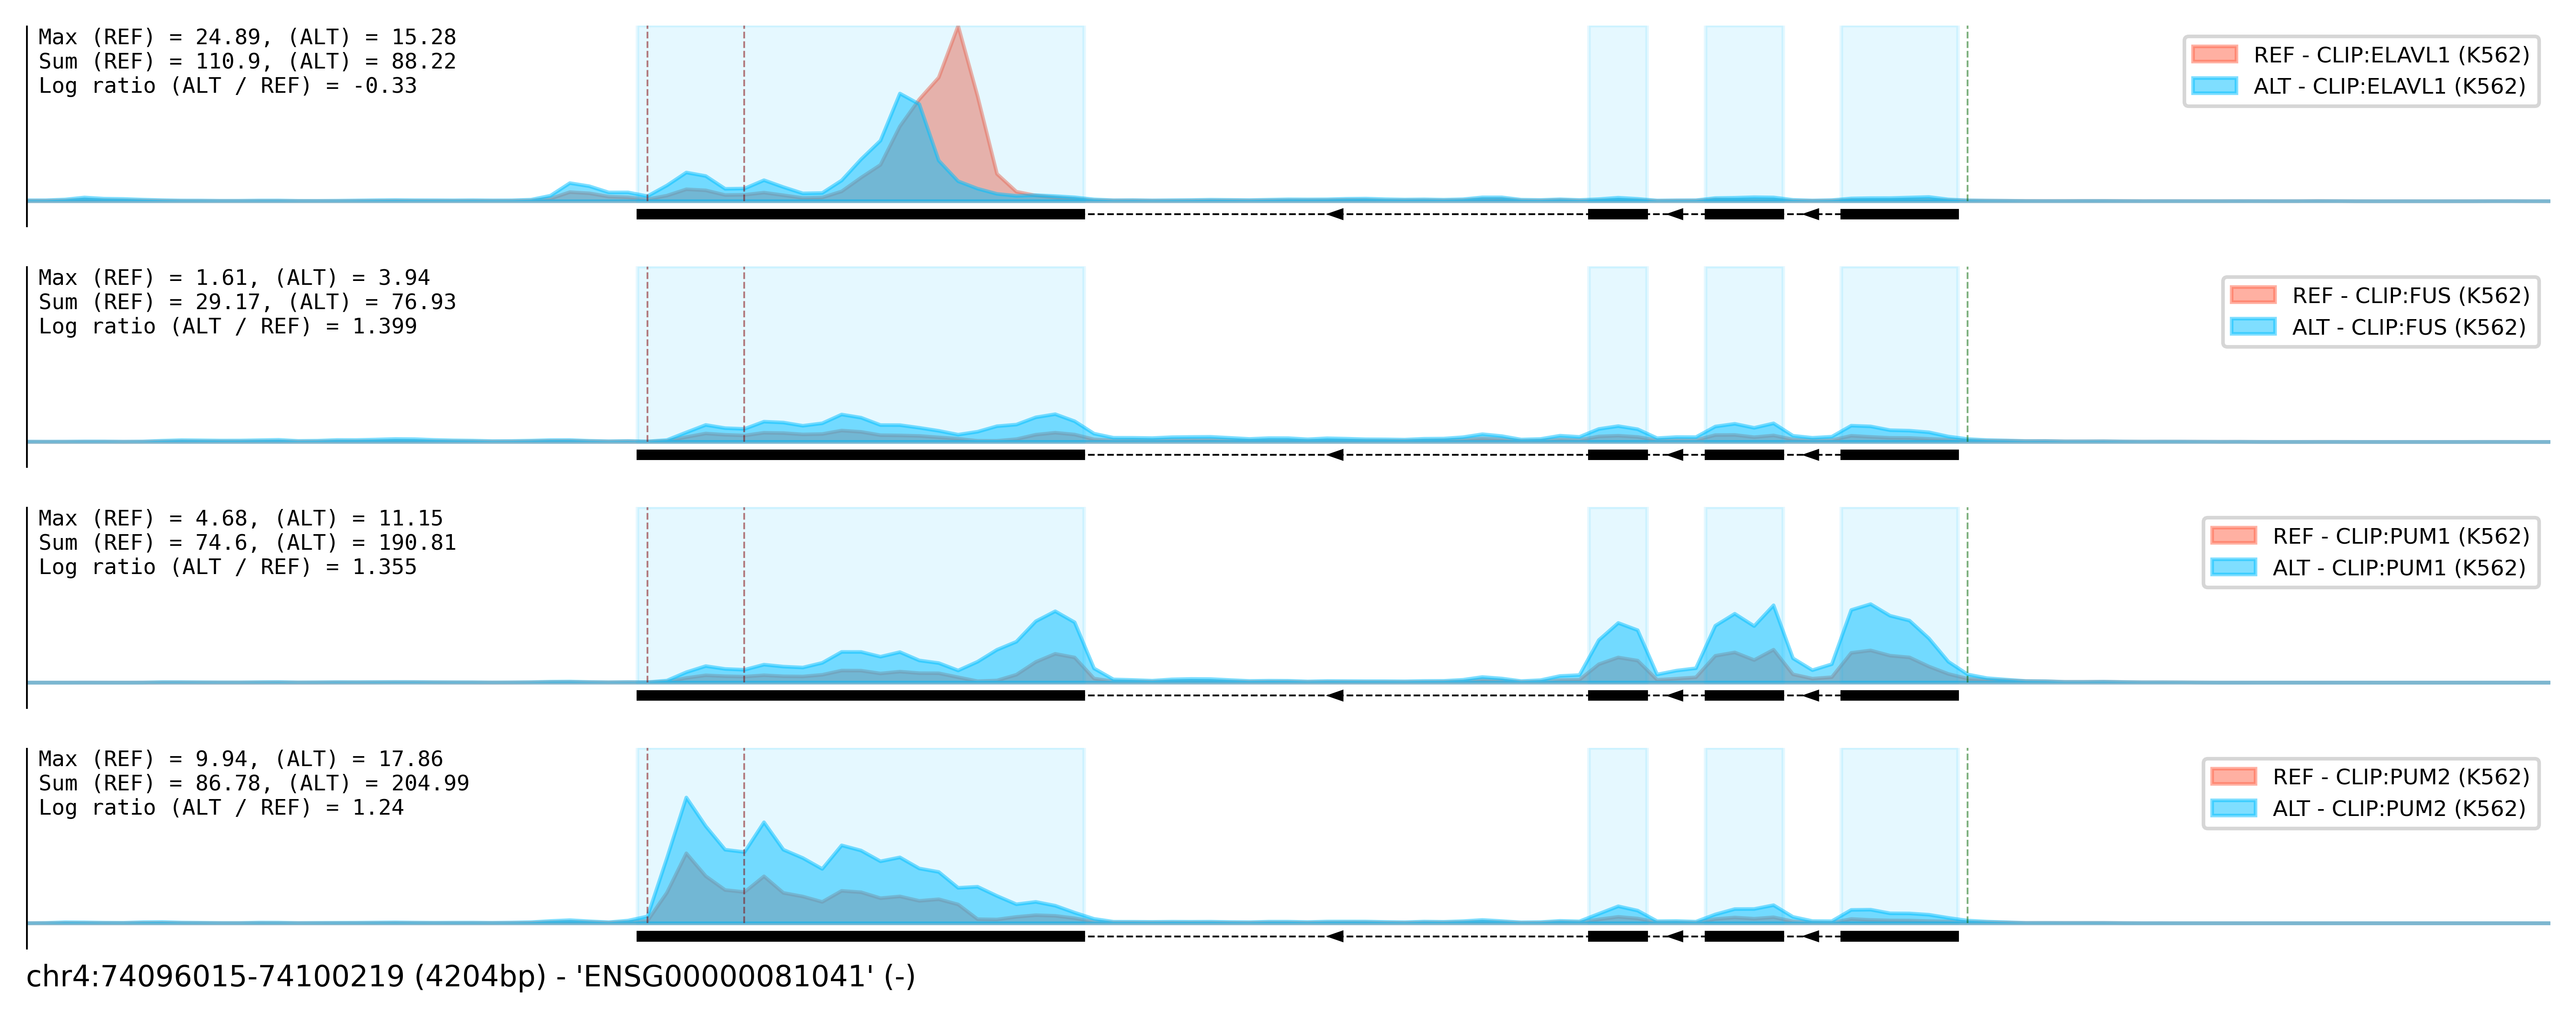

In [16]:
#Visualize quantized tracks

save_figs = True
save_suffix = '_CXCL2_CLIP_encode_shuffle'

plot_start = g_start - start - 1024
plot_end = g_end - start + 1024
bin_size = 32
pad = 0

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero(((targets_df['description'] == 'CLIP:ELAVL1:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:FUS:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:PUM1:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
    np.nonzero(((targets_df['description'] == 'CLIP:PUM2:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)).values)[0].tolist(),
]

track_names = [
    'CLIP:ELAVL1 (K562)',
    'CLIP:FUS (K562)',
    'CLIP:PUM1 (K562)',
    'CLIP:PUM2 (K562)',
]

track_files = [
    targets_df.loc[(targets_df['description'] == 'CLIP:ELAVL1:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:FUS:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:PUM1:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
    targets_df.loc[(targets_df['description'] == 'CLIP:PUM2:K562') & targets_df['identifier'].str.contains("\\" + gene_strand)]['file'].values.tolist(),
]

track_colors = [
    ['tomato', 'deepskyblue'],
    ['tomato', 'deepskyblue'],
    ['tomato', 'deepskyblue'],
    ['tomato', 'deepskyblue'],
]

track_labels = [
    ['REF', 'ALT'],
    ['REF', 'ALT'],
    ['REF', 'ALT'],
    ['REF', 'ALT'],
]

track_scale = 1.#2.0
track_transform = 1./2.
soft_clip = 384.

print("--- Predicted (Borzoi) ---")

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    normalize_counts=False,
    normalize_start_rel=0,
    normalize_end_rel=393216,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=[],
    isoform_slices=[],
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=[],
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=False,
)


In [ ]:
#Get contribution scores (ISM) for time-course

#Tracks
track_indices = [
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__8h__rep.')).values)[0].tolist(),
]

rel_start = 74097023 - start - 100
rel_end = 74097783 - start + 100

pred_isms = []

for track_i, track_index in enumerate(track_indices) :
    
    print("Computing scores for track_i = " + str(track_i) + "...")
    
    [pred_ism_wt_xh] = get_ism(
        models,
        [seq_1hot_wt],
        rel_start,
        rel_end,
        0,
        1,
        0,
        1,
        track_index,
        0.02,
        1./2.,
        384.,
        dist_bin_index=gene_slice.tolist(),
        use_mean=True,
        use_ratio=False,
        use_logodds=False,
        untransform_old=False,
    )
    
    pred_isms.append(pred_ism_wt_xh[None, ...])

pred_ism = np.concatenate(pred_isms, axis=0)

print("pred_ism.shape = " + str(pred_ism.shape))

#Cache ISM
np.save('borzoi_halflife_example_ActD_ism_CXCL2', pred_ism)


In [19]:

pred_ism = np.load('borzoi_halflife_example_ActD_ism_CXCL2.npy')


In [20]:

pred_ism_wt_0h = pred_ism[0, ...]
pred_ism_wt_8h = pred_ism[-1, ...]


--- WT ---


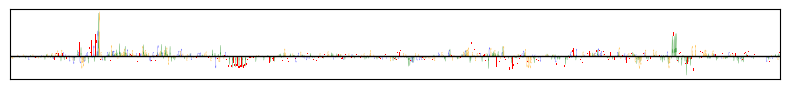

--- Mut ---


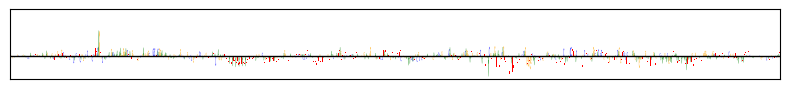

In [21]:
#Visualize contribution scores (ISM)

visualize_input_gradient_pair(
    pred_ism_wt_0h[::-1, ::-1],
    pred_ism_wt_8h[::-1, ::-1],
    plot_start=393216 - (74097783 - start + 100),
    plot_end=393216 - (74097023 - start - 100),
    save_figs=True,
    fig_name='CXCL2_ism',
)


--- WT ---


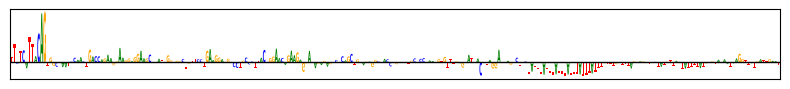

--- Mut ---


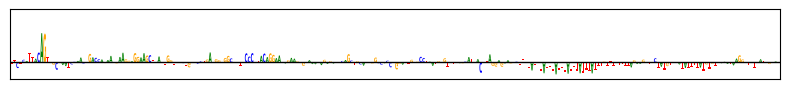

In [22]:
#Visualize contribution scores (ISM)

visualize_input_gradient_pair(
    pred_ism_wt_0h[::-1, ::-1],
    pred_ism_wt_8h[::-1, ::-1],
    plot_start=393216 - (74097783 - start + 100) + 100,
    plot_end=393216 - (74097783 - start + 100) + 100 + 256,
    save_figs=True,
    fig_name='CXCL2_ism_zoom',
)


In [ ]:
#Get contribution scores (ISM Shuffle) for time-course

#Tracks
track_indices = [
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep.')).values)[0].tolist(),
    np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__8h__rep.')).values)[0].tolist(),
]

rel_start = 74097023 - start - 100
rel_end = 74097783 - start + 100

pred_ism_shuffles = []

for track_i, track_index in enumerate(track_indices) :
    
    print("Computing scores for track_i = " + str(track_i) + "...")
    
    [pred_ism_shuffle_wt_xh] = get_ism_shuffle(
        models,
        [seq_1hot_wt],
        rel_start,
        rel_end,
        0,
        1,
        0,
        1,
        track_index,
        0.02,
        1./2.,
        384.,
        window_size=9,
        n_samples=16,
        dist_bin_index=gene_slice.tolist(),
        use_mean=True,
        use_ratio=False,
        use_logodds=False,
        untransform_old=False,
    )
    
    pred_ism_shuffles.append(pred_ism_shuffle_wt_xh[None, ...])

pred_ism_shuffle = np.concatenate(pred_ism_shuffles, axis=0)

print("pred_ism_shuffle.shape = " + str(pred_ism_shuffle.shape))

#Cache ISM
np.save('borzoi_halflife_example_ActD_ism_shuffle_CXCL2', pred_ism_shuffle)


In [16]:

pred_ism_shuffle = np.load('borzoi_halflife_example_ActD_ism_shuffle_CXCL2.npy')


In [17]:

pred_ism_shuffle_wt_0h = pred_ism_shuffle[0, ...]
pred_ism_shuffle_wt_8h = pred_ism_shuffle[-1, ...]


--- WT ---


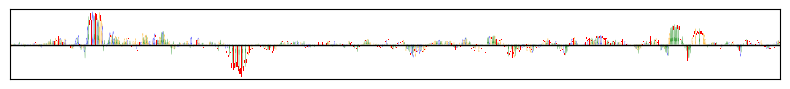

--- Mut ---


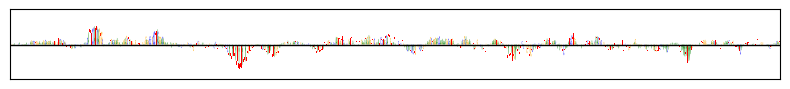

In [18]:
#Visualize contribution scores (ISM Shuffle)

visualize_input_gradient_pair(
    pred_ism_shuffle_wt_0h[::-1, ::-1],
    pred_ism_shuffle_wt_8h[::-1, ::-1],
    plot_start=393216 - (74097783 - start + 100),
    plot_end=393216 - (74097023 - start - 100),
    save_figs=True,
    fig_name='CXCL2_ism_shuffle',
)


--- WT ---


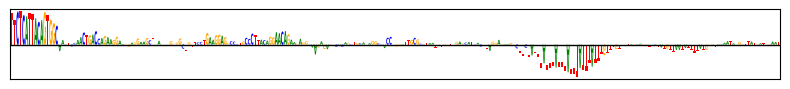

--- Mut ---


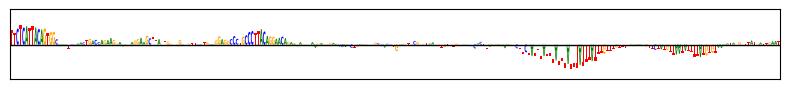

In [19]:
#Visualize contribution scores (ISM Shuffle)

visualize_input_gradient_pair(
    pred_ism_shuffle_wt_0h[::-1, ::-1],
    pred_ism_shuffle_wt_8h[::-1, ::-1],
    plot_start=393216 - (74097783 - start + 100) + 100,
    plot_end=393216 - (74097783 - start + 100) + 100 + 256,
    save_figs=True,
    fig_name='CXCL2_ism_shuffle_zoom',
)


In [8]:
#Helper function to compute ISM that stores scores for all output tracks

def _prediction_ism_score_m(pred, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, use_mean, use_ratio, use_logodds, prox_bin_index, dist_bin_index) :

    if not use_mean :
        if dist_bin_index is None :
            mean_dist = np.sum(pred[:, dist_bin_start:dist_bin_end, :], axis=1)
        else :
            mean_dist = np.sum(pred[:, dist_bin_index, :], axis=1)
        if prox_bin_index is None :
            mean_prox = np.sum(pred[:, prox_bin_start:prox_bin_end, :], axis=1)
        else :
            mean_prox = np.sum(pred[:, prox_bin_index, :], axis=1)
    else:
        if dist_bin_index is None :
            mean_dist = np.mean(pred[:, dist_bin_start:dist_bin_end, :], axis=1)
        else :
            mean_dist = np.mean(pred[:, dist_bin_index, :], axis=1)
        if prox_bin_index is None :
            mean_prox = np.mean(pred[:, prox_bin_start:prox_bin_end, :], axis=1)
        else :
            mean_prox = np.mean(pred[:, prox_bin_index, :], axis=1)
    
    if not use_ratio :
        mean_dist_prox_ratio = np.log(mean_dist + 1e-6)
    else :
        if not use_logodds :
            mean_dist_prox_ratio = np.log(mean_dist / mean_prox + 1e-6)
        else :
            mean_dist_prox_ratio = np.log((mean_dist / mean_prox) / (1. - (mean_dist / mean_prox)) + 1e-6)

    return mean_dist_prox_ratio

def get_ism_m(models, sequence_one_hots, ism_start, ism_end, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, track_scale, track_transform, clip_soft, prox_bin_index=None, dist_bin_index=None, use_mean=False, use_ratio=True, use_logodds=False) :
    
    pred_ism = np.zeros((len(sequence_one_hots), len(models), 393216, 4, models[0].num_targets()))
    
    bases = [0, 1, 2, 3]
    
    for example_ix in range(len(sequence_one_hots)) :
        
        print("example_ix = " + str(example_ix))
        
        sequence_one_hot_wt = sequence_one_hots[example_ix]
        
        # get pred
        y_wt = predict_tracks(models, sequence_one_hot_wt)[0, ...].astype('float32')
        
        # undo soft_clip
        if clip_soft is not None :
            y_wt_unclipped = (y_wt - clip_soft + 1)**2 + clip_soft - 1
            unclip_mask_wt = (y_wt > clip_soft)

            y_wt[unclip_mask_wt] = y_wt_unclipped[unclip_mask_wt]

        # undo sqrt
        y_wt = (y_wt + 1)**(1. / track_transform) - 1
        
        # undo scale
        y_wt /= track_scale
        
        score_wt = _prediction_ism_score_m(y_wt, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, use_mean, use_ratio, use_logodds, prox_bin_index, dist_bin_index)
        
        for j in range(ism_start, ism_end) :
            for b in bases :
                if sequence_one_hot_wt[j, b] != 1. : 
                    sequence_one_hot_mut = np.copy(sequence_one_hot_wt)
                    sequence_one_hot_mut[j, :] = 0.
                    sequence_one_hot_mut[j, b] = 1.
                    
                    # get pred
                    y_mut = predict_tracks(models, sequence_one_hot_mut)[0, ...].astype('float32')

                    # undo soft_clip
                    if clip_soft is not None :
                        y_mut_unclipped = (y_mut - clip_soft + 1)**2 + clip_soft - 1
                        unclip_mask_mut = (y_mut > clip_soft)

                        y_mut[unclip_mask_mut] = y_mut_unclipped[unclip_mask_mut]

                    # undo sqrt
                    y_mut = (y_mut + 1)**(1. / track_transform) - 1

                    # undo scale
                    y_mut /= track_scale
                    
                    score_mut = _prediction_ism_score_m(y_mut, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, use_mean, use_ratio, use_logodds, prox_bin_index, dist_bin_index)
                    
                    pred_ism[example_ix, :, j, b, :] = score_wt - score_mut
        
    pred_ism = [pred_ism[example_ix, ...] for example_ix in range(len(sequence_one_hots))]
    
    return pred_ism


In [ ]:
#Re-load model (only RNA-seq)

targets_file = 'targets_human_rna.txt'

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

target_slice = np.array(targets_df.index.values, dtype='int32')

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = np.array(targets_df.strand_pair.values, dtype='int32')
    
    #Create local index of strand_pair (relative to sliced targets)
    target_slice_dict = {ix : i for i, ix in enumerate(target_slice.tolist())}
    slice_pair = np.array([target_slice_dict[ix] for ix in strand_pair.tolist()], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "models/f" + str(fold_ix) + "c0/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


In [ ]:
#Get contribution scores (ISM) for time-course

rel_start = 74097783 - start - 256
rel_end = 74097783 - start

[pred_ism] = get_ism_m(
    models,
    [seq_1hot_wt],
    rel_start,
    rel_end,
    0,
    1,
    0,
    1,
    0.02,
    1./2.,
    384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)

#Cache ISM
np.save('borzoi_halflife_example_ActD_ism_CXCL2_m', pred_ism)


In [9]:
#Load ISM (potentially from multiple model instances)

ism_file_paths = [
    'borzoi_halflife_example_ActD_ism_CXCL2_m.npy',
]

pred_ism = None

for ism_file_path in ism_file_paths :
    if pred_ism is None :
        pred_ism = np.load(ism_file_path)
    else :
        pred_ism = np.concatenate([pred_ism, np.load(ism_file_path)], axis=0)


In [12]:
#Load CXCL2 mutagenesis data (Zhao 2014)

mpra_df = pd.read_csv('mutagenesis_MPRA.txt', sep='\t')

true_ism = np.array(mpra_df[['A', 'C', 'G', 'T']].values, dtype='float32')[::-1, :]


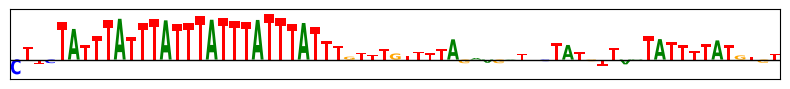

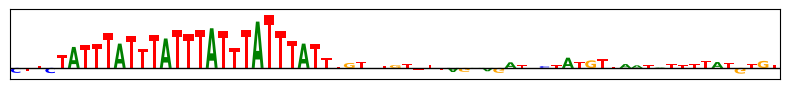

Pearson r = 0.6914
Spearman r = 0.6677
n = 195


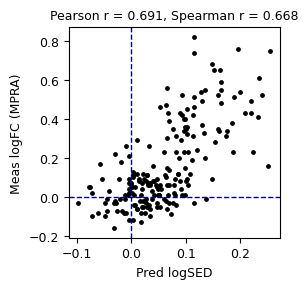

In [16]:
#Visualize contribution scores (Rinn ActD K562), zoom in on ARE element

from scipy.stats import pearsonr, spearmanr

target_index_0h = np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep')).values)[0].tolist()

pred_ism_wt_0h = np.mean(np.mean(pred_ism, axis=0)[..., target_index_0h], axis=-1)[::-1, ::-1]

start_j = 197110
end_j = 197177

pred_ism_wt_0h_slice = pred_ism_wt_0h[start_j:end_j, :]

seq_1hot_wt_slice = seq_1hot_wt[::-1, ::-1][start_j:end_j, :]

plot_seq_scores(
    -np.mean(pred_ism_wt_0h_slice, axis=-1, keepdims=True) * seq_1hot_wt_slice,
    figsize=(8, 1),
    plot_y_ticks=False,
    save_figs=False,
    fig_name='CXCL2_ft_ARE_pred',
)

plot_seq_scores(
    np.mean(true_ism, axis=-1, keepdims=True) * seq_1hot_wt_slice,
    figsize=(8, 1),
    plot_y_ticks=False,
    save_figs=False,
    fig_name='CXCL2_ft_ARE_true',
)
#Plot scatter between predicted and measured variant effects
f = plt.figure(figsize=(3, 3))

y_p = -np.ravel(pred_ism_wt_0h_slice)
y_t = np.ravel(true_ism)

y_p = y_p[y_t != 0.]
y_t = y_t[y_t != 0.]

r_p, _ = pearsonr(y_p, y_t)
r_s, _ = spearmanr(y_p, y_t)

print("Pearson r = " + str(round(r_p, 4)))
print("Spearman r = " + str(round(r_s, 4)))
print("n = " + str(y_p.shape[0]))

plt.scatter(
    y_p,
    y_t,
    color='black',
    s=6,
)

plt.axhline(y=0., color='darkblue', linewidth=1, linestyle='--')
plt.axvline(x=0., color='darkblue', linewidth=1, linestyle='--')

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.xlabel("Pred logSED", fontsize=9)
plt.ylabel("Meas logFC (MPRA)", fontsize=9)

plt.title('Pearson r = ' + str(round(r_p, 3)) + ', Spearman r = ' + str(round(r_s, 3)), fontsize=9)

plt.tight_layout()

plt.savefig('CXCL2_mpra_scatter_actd_k562.eps')

plt.show()


In [17]:
#Load ISM (from all 6 model replicates)

ism_file_paths = [
    'borzoi_halflife_example_ActD_ism_CXCL2_m.npy',
    'borzoi_halflife_example_ActD_ism_CXCL2_m_retry1.npy',
    'borzoi_halflife_example_ActD_ism_CXCL2_m_retry2.npy',
]

pred_ism = None

for ism_file_path in ism_file_paths :
    if pred_ism is None :
        pred_ism = np.load(ism_file_path)
    else :
        pred_ism = np.concatenate([pred_ism, np.load(ism_file_path)], axis=0)


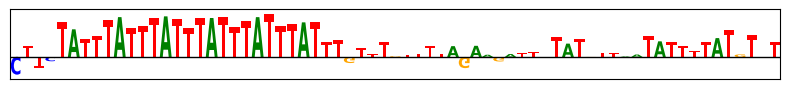

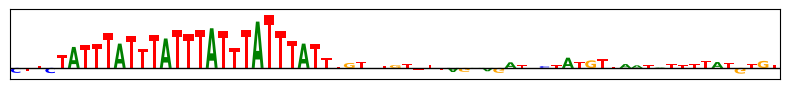

Pearson r = 0.695
Spearman r = 0.676
n = 195


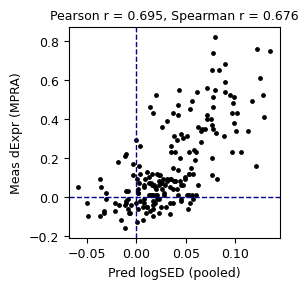

In [18]:
#Visualize contribution scores (Rinn ActD K562), zoom in on ARE element

from scipy.stats import pearsonr, spearmanr

target_index_0h = np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep')).values)[0].tolist()

pred_ism_wt_0h = np.mean(np.mean(pred_ism, axis=0)[..., target_index_0h], axis=-1)[::-1, ::-1]

start_j = 197110
end_j = 197177

pred_ism_wt_0h_slice = pred_ism_wt_0h[start_j:end_j, :]

seq_1hot_wt_slice = seq_1hot_wt[::-1, ::-1][start_j:end_j, :]

plot_seq_scores(
    -np.mean(pred_ism_wt_0h_slice, axis=-1, keepdims=True) * seq_1hot_wt_slice,
    figsize=(8, 1),
    plot_y_ticks=False,
    save_figs=False,
    fig_name='CXCL2_ft_ARE_pred',
)

plot_seq_scores(
    np.mean(true_ism, axis=-1, keepdims=True) * seq_1hot_wt_slice,
    figsize=(8, 1),
    plot_y_ticks=False,
    save_figs=False,
    fig_name='CXCL2_ft_ARE_true',
)
#Plot scatter between predicted and measured variant effects
f = plt.figure(figsize=(3, 3))

y_p = -np.ravel(pred_ism_wt_0h_slice)
y_t = np.ravel(true_ism)

y_p = y_p[y_t != 0.]
y_t = y_t[y_t != 0.]

r_p, _ = pearsonr(y_p, y_t)
r_s, _ = spearmanr(y_p, y_t)

print("Pearson r = " + str(round(r_p, 4)))
print("Spearman r = " + str(round(r_s, 4)))
print("n = " + str(y_p.shape[0]))

plt.scatter(
    y_p,
    y_t,
    color='black',
    s=6,
)

plt.axhline(y=0., color='darkblue', linewidth=1, linestyle='--')
plt.axvline(x=0., color='darkblue', linewidth=1, linestyle='--')

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.xlabel("Pred logSED (pooled)", fontsize=9)
plt.ylabel("Meas dExpr (MPRA)", fontsize=9)

plt.title('Pearson r = ' + str(round(r_p, 3)) + ', Spearman r = ' + str(round(r_s, 3)), fontsize=9)

plt.tight_layout()

plt.savefig('CXCL2_mpra_scatter_actd_k562_6_reps.eps')

plt.show()


rep_ix = 0
--- WT ---


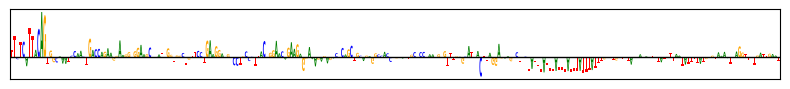

--- Mut ---


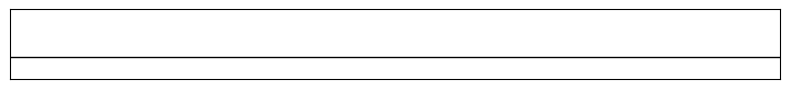

rep_ix = 1
--- WT ---


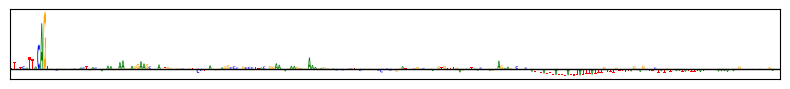

--- Mut ---


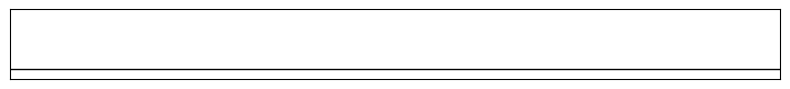

rep_ix = 2
--- WT ---


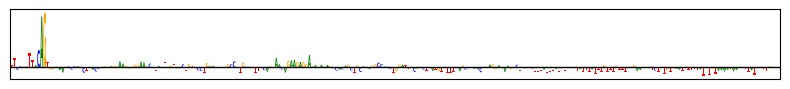

--- Mut ---


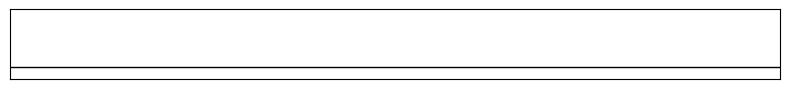

rep_ix = 3
--- WT ---


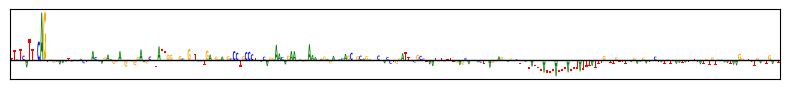

--- Mut ---


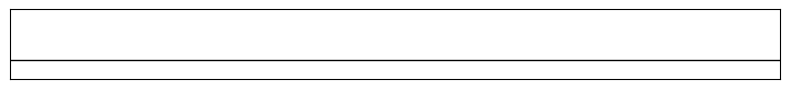

rep_ix = 4
--- WT ---


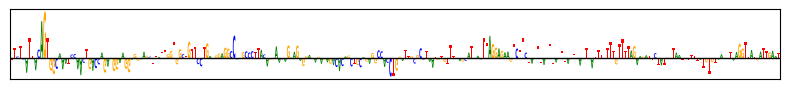

--- Mut ---


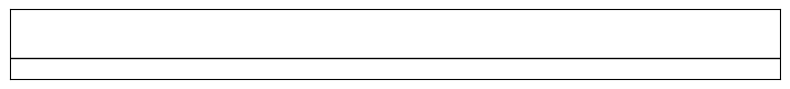

rep_ix = 5
--- WT ---


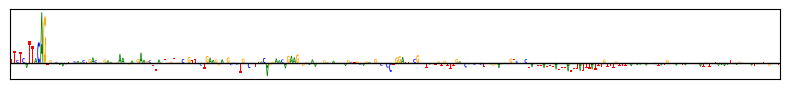

--- Mut ---


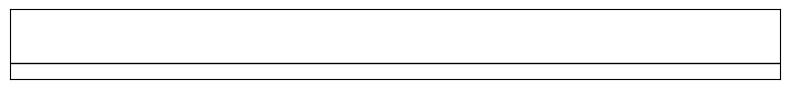

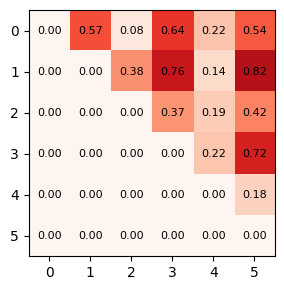

In [20]:
#Visualize contribution scores (Rinn ActD K562), per fold

target_index_0h = np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep')).values)[0].tolist()

pred_ism_wt_0h = np.mean(np.mean(pred_ism[..., target_index_0h], axis=-1), axis=-1, keepdims=True) * seq_1hot_wt[None, ...]
pred_ism_wt_0h_all = np.mean(pred_ism[..., target_index_0h], axis=-1)

y_p_fold = []

for rep_ix in range(pred_ism_wt_0h.shape[0]) :
    
    print("rep_ix = " + str(rep_ix))

    visualize_input_gradient_pair(
        pred_ism_wt_0h[rep_ix, ...][::-1, ::-1],
        np.zeros(pred_ism_wt_0h[rep_ix, ...][::-1, ::-1].shape),
        plot_start=393216 - (74097783 - start + 100) + 100,
        plot_end=393216 - (74097783 - start + 100) + 100 + 256,
    )
    
    #Slice MPRA regions
    start_j = 393216 - (74097783 - start + 100) + 100 + 128 + 40
    end_j = 393216 - (74097783 - start + 100) + 100 + 256 - 21
    
    y_p = -np.ravel(pred_ism_wt_0h_all[rep_ix, ...][::-1, ::-1][start_j:end_j, :])
    y_p_fold.append(y_p[y_p != 0.])

y_p_fold = np.array(y_p_fold, dtype='float32')

#Compute pairwise spearman correlations and plot as heatmap
rs_mat = np.zeros((y_p_fold.shape[0], y_p_fold.shape[0]))
for rep_ix in range(rs_mat.shape[0]) :
    for rep_ix2 in range(rep_ix + 1, rs_mat.shape[1]) :
        rs_mat[rep_ix, rep_ix2] = spearmanr(y_p_fold[rep_ix, :], y_p_fold[rep_ix2, :])[0]

f = plt.figure(figsize=(3, 3))

plt.imshow(rs_mat, cmap='Reds', vmin=0., vmax=1., aspect='equal')

for y in range(rs_mat.shape[0]):
    for x in range(rs_mat.shape[1]):
        plt.text(x, y, '%.2f' % rs_mat[y, x], fontsize=8, horizontalalignment='center', verticalalignment='center')

plt.xticks(np.arange(rs_mat.shape[0]), np.arange(rs_mat.shape[0]), fontsize=10)
plt.yticks(np.arange(rs_mat.shape[0]), np.arange(rs_mat.shape[0]), fontsize=10)

plt.tight_layout()

plt.savefig('CXCL2_mpra_heatmap_actd_k562_6_reps.eps')

plt.show()


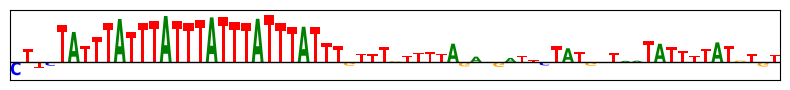

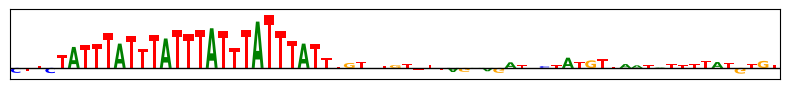

Pearson r = 0.7164
Spearman r = 0.684
n = 195


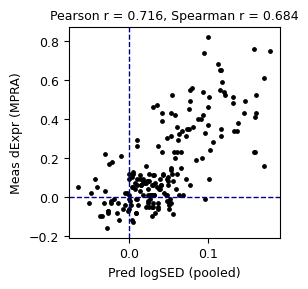

In [19]:
#Visualize contribution scores (Rinn ActD K562), zoom in on ARE element

from scipy.stats import pearsonr, spearmanr

target_index_0h = np.nonzero((targets_df['description'].str.contains('RNA:ActD:K562__0\.0h__rep')).values)[0].tolist()

pred_ism_wt_0h = np.mean(np.mean(pred_ism[[0, 1, 3, 5], ...], axis=0)[..., target_index_0h], axis=-1)[::-1, ::-1]

start_j = 197110
end_j = 197177

pred_ism_wt_0h_slice = pred_ism_wt_0h[start_j:end_j, :]

seq_1hot_wt_slice = seq_1hot_wt[::-1, ::-1][start_j:end_j, :]

plot_seq_scores(
    -np.mean(pred_ism_wt_0h_slice, axis=-1, keepdims=True) * seq_1hot_wt_slice,
    figsize=(8, 1),
    plot_y_ticks=False,
    save_figs=False,
    fig_name='CXCL2_ft_ARE_pred',
)

plot_seq_scores(
    np.mean(true_ism, axis=-1, keepdims=True) * seq_1hot_wt_slice,
    figsize=(8, 1),
    plot_y_ticks=False,
    save_figs=False,
    fig_name='CXCL2_ft_ARE_true',
)
#Plot scatter between predicted and measured variant effects
f = plt.figure(figsize=(3, 3))

y_p = -np.ravel(pred_ism_wt_0h_slice)
y_t = np.ravel(true_ism)

y_p = y_p[y_t != 0.]
y_t = y_t[y_t != 0.]

r_p, _ = pearsonr(y_p, y_t)
r_s, _ = spearmanr(y_p, y_t)

print("Pearson r = " + str(round(r_p, 4)))
print("Spearman r = " + str(round(r_s, 4)))
print("n = " + str(y_p.shape[0]))

plt.scatter(
    y_p,
    y_t,
    color='black',
    s=6,
)

plt.axhline(y=0., color='darkblue', linewidth=1, linestyle='--')
plt.axvline(x=0., color='darkblue', linewidth=1, linestyle='--')

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.xlabel("Pred logSED (pooled)", fontsize=9)
plt.ylabel("Meas dExpr (MPRA)", fontsize=9)

plt.title('Pearson r = ' + str(round(r_p, 3)) + ', Spearman r = ' + str(round(r_s, 3)), fontsize=9)

plt.tight_layout()

plt.savefig('CXCL2_mpra_scatter_actd_k562_6_reps_pruned.eps')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


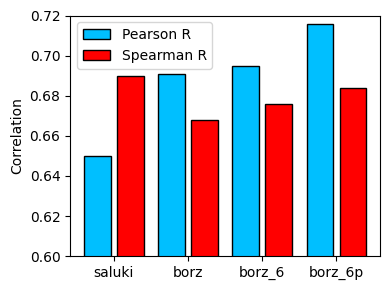

In [21]:
#Plot overview barchart of model performance metrics

model_names = [
    'saluki',
    'borz',
    'borz_6',
    'borz_6p',
]

corrs = np.array([
    [0.650, 0.690],
    [0.691, 0.668],
    [0.695, 0.676],
    [0.716, 0.684],
], dtype='float32')

f = plt.figure(figsize=(4, 3))

x = np.arange(len(model_names), dtype='int32')

plt.bar(x * 2.25, corrs[:, 0], color='deepskyblue', linewidth=1, edgecolor='black', label='Pearson R')
plt.bar(x * 2.25 + 1, corrs[:, 1], color='red', linewidth=1, edgecolor='black', label='Spearman R')

plt.ylim(0.60, 0.72)

plt.xticks(x * 2.25 + 0.5, model_names, fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("Correlation", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.savefig('CXCL2_mpra_bars.eps')

plt.show()
